In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/GINECOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=80.9, y1=102.1
Page 1, Q1, A: Yellow pixels: 775
Page 1, Q1, A: Total non-white pixels: 882
Page 1, Q1, A: Yellow percentage: 87.9%


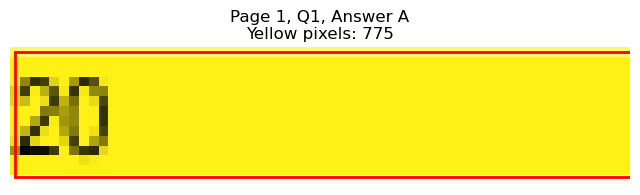

Page 1, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=80.9, y1=114.7
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 108
Page 1, Q1, B: Yellow percentage: 0.0%


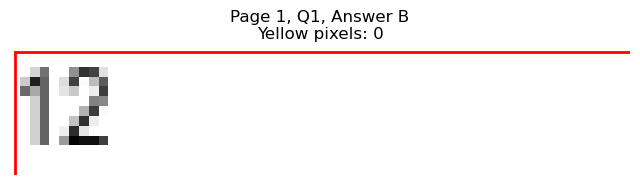

Page 1, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=340.1, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 56
Page 1, Q1, C: Yellow percentage: 0.0%


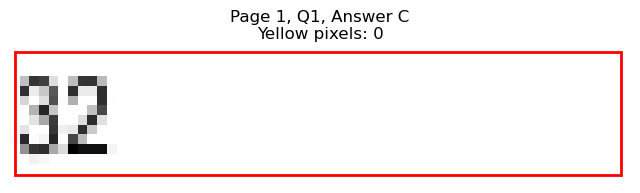

Page 1, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=340.1, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 66
Page 1, Q1, D: Yellow percentage: 0.0%


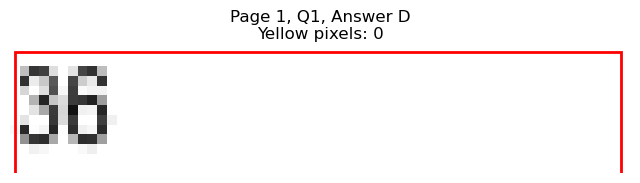


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=65.2, y1=165.2
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 53
Page 1, Q2, A: Yellow percentage: 0.0%


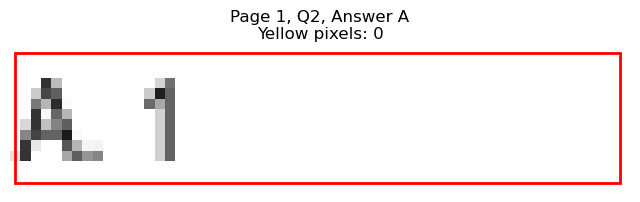

Page 1, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=65.2, y1=177.8
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 73
Page 1, Q2, B: Yellow percentage: 0.0%


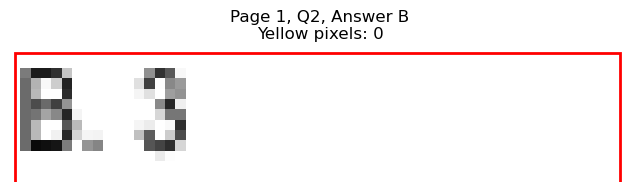

Page 1, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=324.4, y1=165.2
Page 1, Q2, C: Yellow pixels: 735
Page 1, Q2, C: Total non-white pixels: 840
Page 1, Q2, C: Yellow percentage: 87.5%


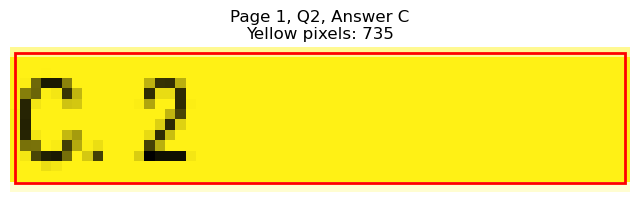

Page 1, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 129
Page 1, Q2, D: Yellow percentage: 0.0%


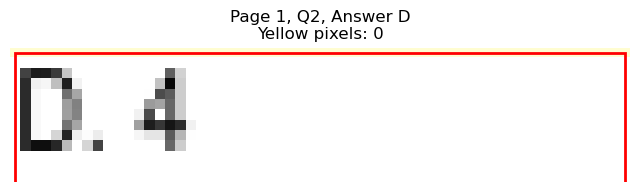


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=153.0, y1=240.9
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 369
Page 1, Q3, A: Yellow percentage: 0.0%


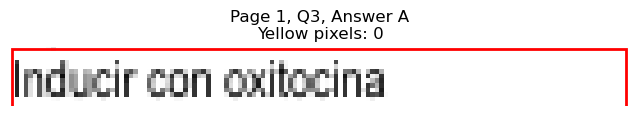

Page 1, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=180.1, y1=253.5
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 537
Page 1, Q3, B: Yellow percentage: 0.0%


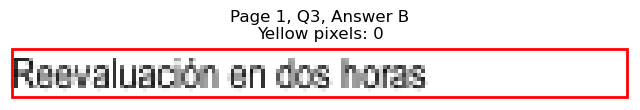

Page 1, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=453.9, y1=240.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 836
Page 1, Q3, C: Yellow percentage: 0.0%


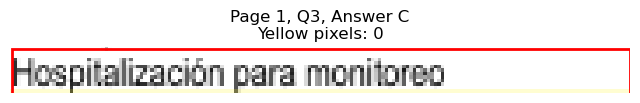

Page 1, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=426.3, y1=253.5
Page 1, Q3, D: Yellow pixels: 1549
Page 1, Q3, D: Total non-white pixels: 2100
Page 1, Q3, D: Yellow percentage: 73.8%


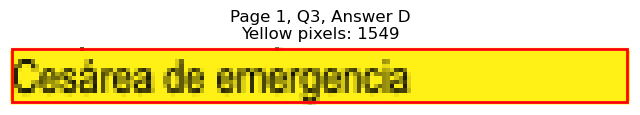


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=183.6, y1=304.1
Page 1, Q4, A: Yellow pixels: 166
Page 1, Q4, A: Total non-white pixels: 754
Page 1, Q4, A: Yellow percentage: 22.0%


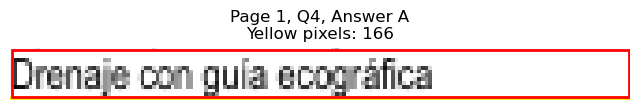

Page 1, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=121.5, y1=316.7
Page 1, Q4, B: Yellow pixels: 1133
Page 1, Q4, B: Total non-white pixels: 1352
Page 1, Q4, B: Yellow percentage: 83.8%


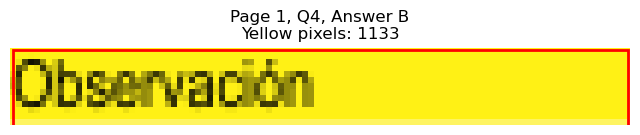

Page 1, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=441.4, y1=304.1
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 592
Page 1, Q4, C: Yellow percentage: 0.0%


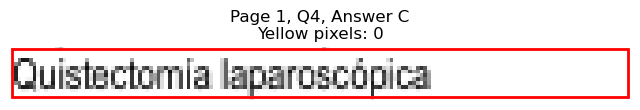

Page 1, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=380.7, y1=316.7
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 260
Page 1, Q4, D: Yellow percentage: 0.0%


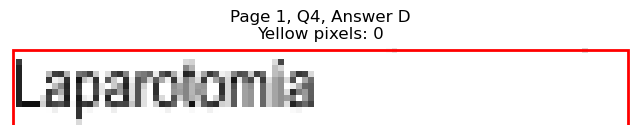


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=257.0, y1=392.4
Page 1, Q5, A: Yellow pixels: 213
Page 1, Q5, A: Total non-white pixels: 1157
Page 1, Q5, A: Yellow percentage: 18.4%


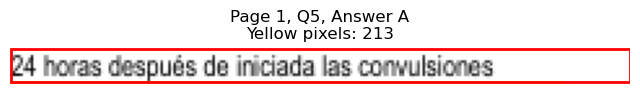

Page 1, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=180.1, y1=405.0
Page 1, Q5, B: Yellow pixels: 1696
Page 1, Q5, B: Total non-white pixels: 2119
Page 1, Q5, B: Yellow percentage: 80.0%


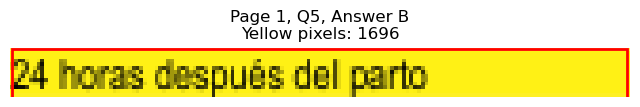

Page 1, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=478.5, y1=392.4
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 738
Page 1, Q5, C: Yellow percentage: 0.0%


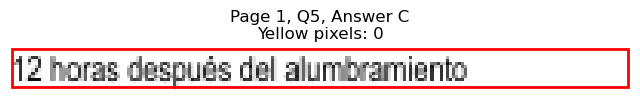

Page 1, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=516.2, y1=405.0
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 910
Page 1, Q5, D: Yellow percentage: 0.0%


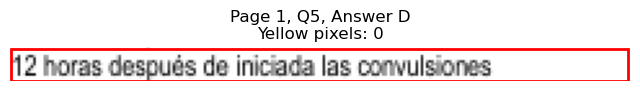


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=102.9, y1=468.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 160
Page 1, Q6, A: Yellow percentage: 0.0%


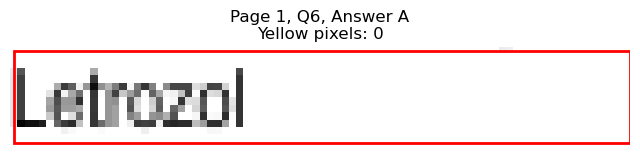

Page 1, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=151.1, y1=480.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 408
Page 1, Q6, B: Yellow percentage: 0.0%


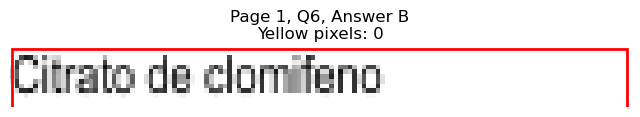

Page 1, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=431.3, y1=468.1
Page 1, Q6, C: Yellow pixels: 155
Page 1, Q6, C: Total non-white pixels: 676
Page 1, Q6, C: Yellow percentage: 22.9%


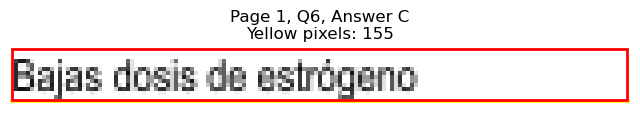

Page 1, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=391.7, y1=480.7
Page 1, Q6, D: Yellow pixels: 1258
Page 1, Q6, D: Total non-white pixels: 1495
Page 1, Q6, D: Yellow percentage: 84.1%


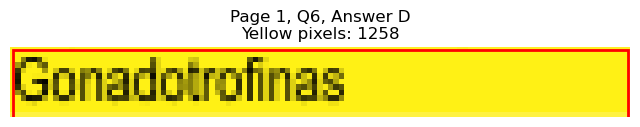


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=151.1, y1=543.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 410
Page 1, Q7, A: Yellow percentage: 0.0%


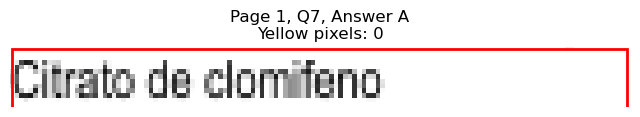

Page 1, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=131.5, y1=556.4
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 324
Page 1, Q7, B: Yellow percentage: 0.0%


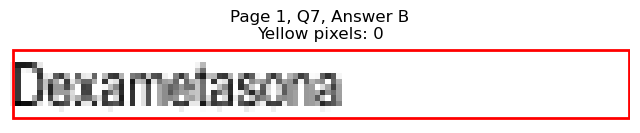

Page 1, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=394.3, y1=543.8
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 469
Page 1, Q7, C: Yellow percentage: 0.0%


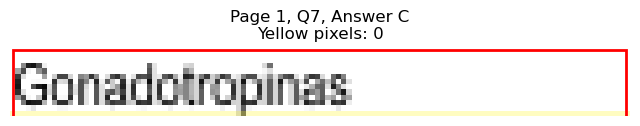

Page 1, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=362.1, y1=556.4
Page 1, Q7, D: Yellow pixels: 999
Page 1, Q7, D: Total non-white pixels: 1204
Page 1, Q7, D: Yellow percentage: 83.0%


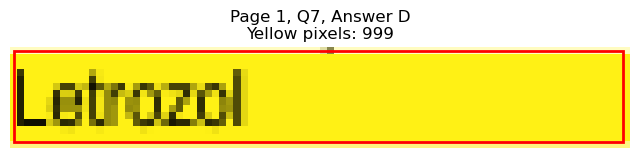


Page 1, Q7 - Selected Answer: D (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=150.5, y1=619.6
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 405
Page 1, Q8, A: Yellow percentage: 0.0%


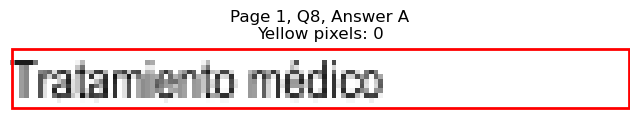

Page 1, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=183.1, y1=632.3
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 626
Page 1, Q8, B: Yellow percentage: 0.0%


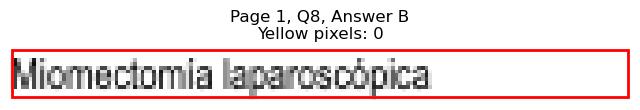

Page 1, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=413.8, y1=619.6
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 469
Page 1, Q8, C: Yellow percentage: 0.0%


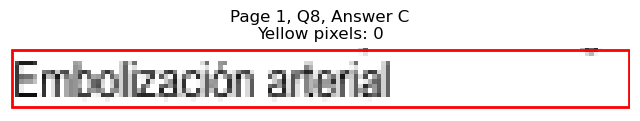

Page 1, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=427.4, y1=632.3
Page 1, Q8, D: Yellow pixels: 1386
Page 1, Q8, D: Total non-white pixels: 2114
Page 1, Q8, D: Yellow percentage: 65.6%


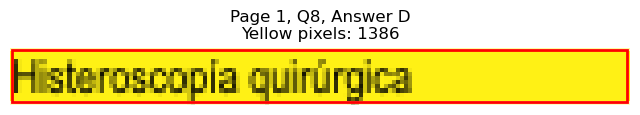


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=135.0, y1=670.1
Page 1, Q9, A: Yellow pixels: 118
Page 1, Q9, A: Total non-white pixels: 451
Page 1, Q9, A: Yellow percentage: 26.2%


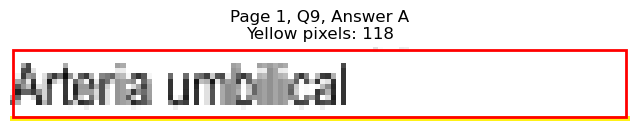

Page 1, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=130.5, y1=682.7
Page 1, Q9, B: Yellow pixels: 1255
Page 1, Q9, B: Total non-white pixels: 1469
Page 1, Q9, B: Yellow percentage: 85.4%


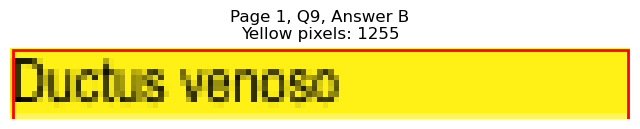

Page 1, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=418.9, y1=670.1
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 462
Page 1, Q9, C: Yellow percentage: 0.0%


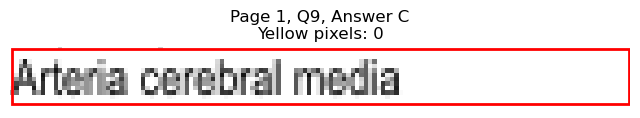

Page 1, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=381.7, y1=682.7
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 260
Page 1, Q9, D: Yellow percentage: 0.0%


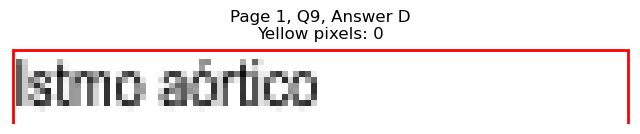


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=154.6, y1=758.4
Page 1, Q10, A: Yellow pixels: 1460
Page 1, Q10, A: Total non-white pixels: 1918
Page 1, Q10, A: Yellow percentage: 76.1%


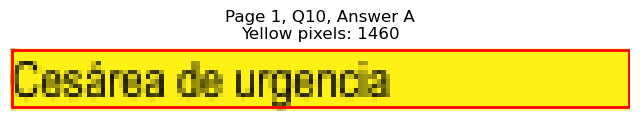

Page 1, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=172.6, y1=771.2
Page 1, Q10, B: Yellow pixels: 153
Page 1, Q10, B: Total non-white pixels: 646
Page 1, Q10, B: Yellow percentage: 23.7%


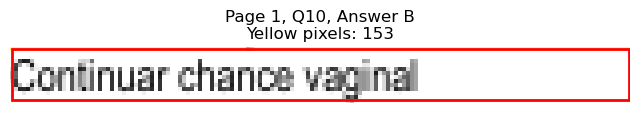

Page 1, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=436.4, y1=758.4
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 543
Page 1, Q10, C: Yellow percentage: 0.0%


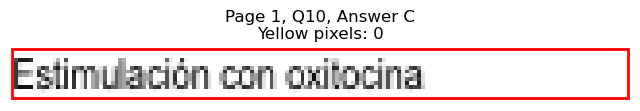

Page 1, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=388.3, y1=771.2
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 321
Page 1, Q10, D: Yellow percentage: 0.0%


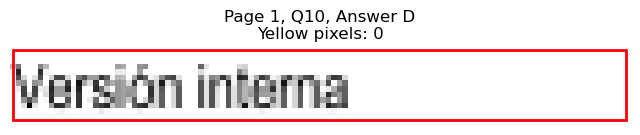


Page 1, Q10 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=164.7, y1=139.9
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 479
Page 2, Q1, A: Yellow percentage: 0.0%


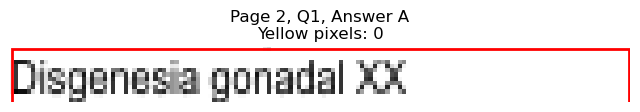

Page 2, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=197.3, y1=152.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 692
Page 2, Q1, B: Yellow percentage: 0.0%


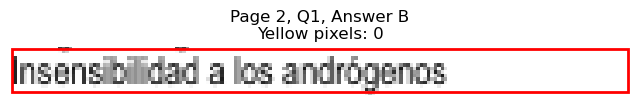

Page 2, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=428.3, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 530
Page 2, Q1, C: Yellow percentage: 0.0%


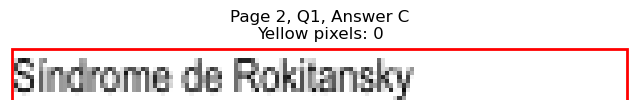

Page 2, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=421.9, y1=152.6
Page 2, Q1, D: Yellow pixels: 1507
Page 2, Q1, D: Total non-white pixels: 2030
Page 2, Q1, D: Yellow percentage: 74.2%


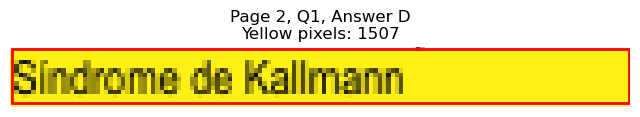


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=147.5, y1=215.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 393
Page 2, Q2, A: Yellow percentage: 0.0%


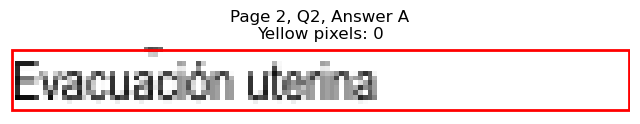

Page 2, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=127.5, y1=228.3
Page 2, Q2, B: Yellow pixels: 1088
Page 2, Q2, B: Total non-white pixels: 1540
Page 2, Q2, B: Yellow percentage: 70.6%


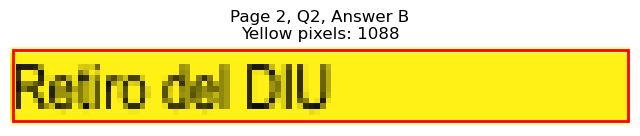

Page 2, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=426.3, y1=215.6
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 478
Page 2, Q2, C: Yellow percentage: 0.0%


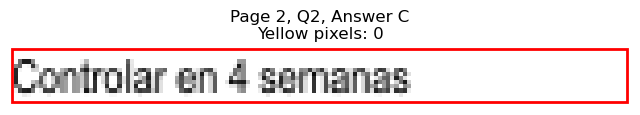

Page 2, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=397.7, y1=228.3
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 357
Page 2, Q2, D: Yellow percentage: 0.0%


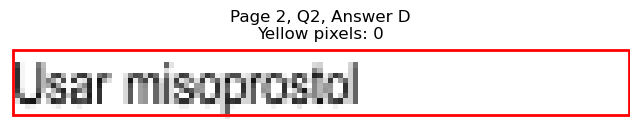


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=115.9, y1=266.1
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 234
Page 2, Q3, A: Yellow percentage: 0.0%


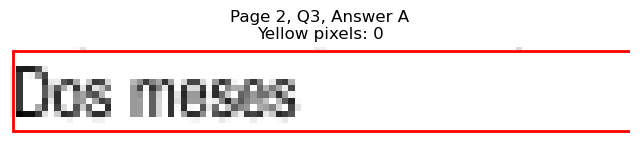

Page 2, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=101.9, y1=278.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 149
Page 2, Q3, B: Yellow percentage: 0.0%


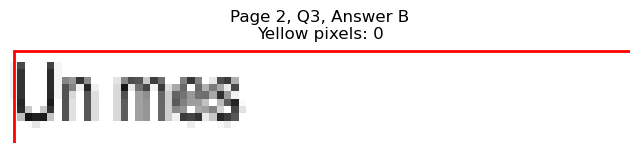

Page 2, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=377.2, y1=266.1
Page 2, Q3, C: Yellow pixels: 1130
Page 2, Q3, C: Total non-white pixels: 1414
Page 2, Q3, C: Yellow percentage: 79.9%


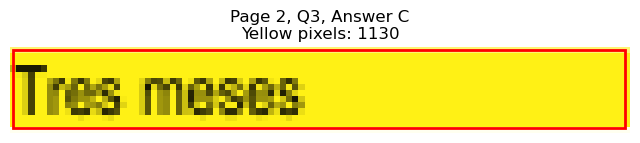

Page 2, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=394.7, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 485
Page 2, Q3, D: Yellow percentage: 0.0%


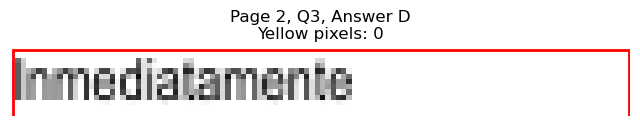


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=144.5, y1=341.9
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 342
Page 2, Q4, A: Yellow percentage: 0.0%


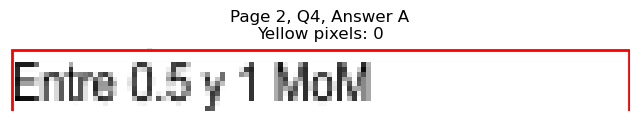

Page 2, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=144.5, y1=354.6
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 331
Page 2, Q4, B: Yellow percentage: 0.0%


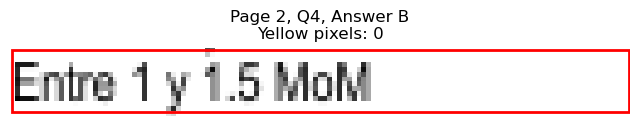

Page 2, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=393.2, y1=341.9
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 330
Page 2, Q4, C: Yellow percentage: 0.0%


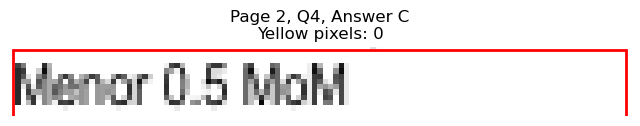

Page 2, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=400.3, y1=354.6
Page 2, Q4, D: Yellow pixels: 1345
Page 2, Q4, D: Total non-white pixels: 1736
Page 2, Q4, D: Yellow percentage: 77.5%


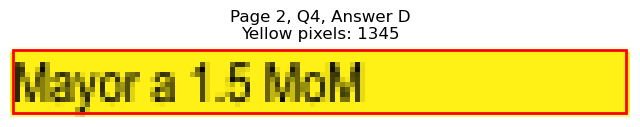


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=161.1, y1=405.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 608
Page 2, Q5, A: Yellow percentage: 0.0%


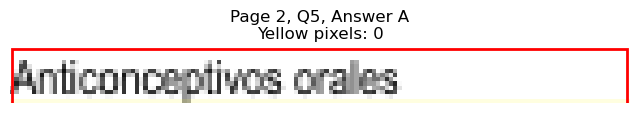

Page 2, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=121.0, y1=417.6
Page 2, Q5, B: Yellow pixels: 1133
Page 2, Q5, B: Total non-white pixels: 1442
Page 2, Q5, B: Yellow percentage: 78.6%


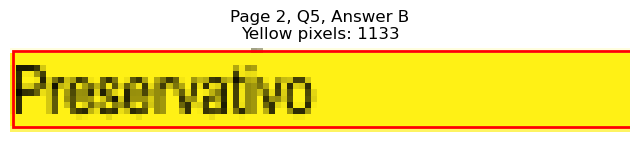

Page 2, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=413.3, y1=405.0
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 447
Page 2, Q5, C: Yellow percentage: 0.0%


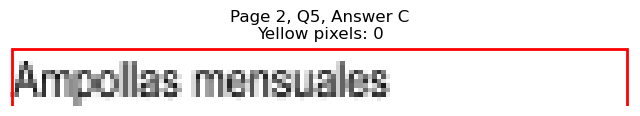

Page 2, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=416.3, y1=417.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 476
Page 2, Q5, D: Yellow percentage: 0.0%


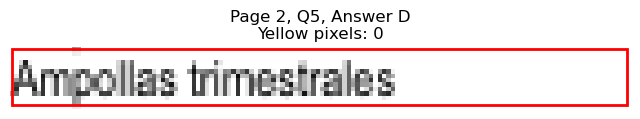


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=298.5, y1=480.7
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 1121
Page 2, Q6, A: Yellow percentage: 0.0%


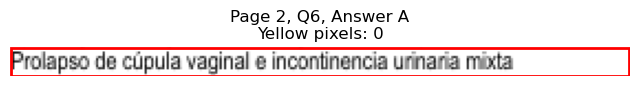

Page 2, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=313.1, y1=493.4
Page 2, Q6, B: Yellow pixels: 296
Page 2, Q6, B: Total non-white pixels: 1499
Page 2, Q6, B: Yellow percentage: 19.7%


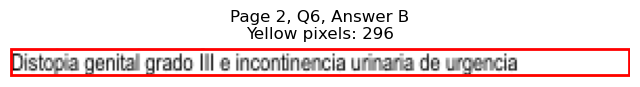

Page 2, Q6 - C: Detected box: x0=68.8, y0=493.4, x1=314.6, y1=506.0
Page 2, Q6, C: Yellow pixels: 2895
Page 2, Q6, C: Total non-white pixels: 3868
Page 2, Q6, C: Yellow percentage: 74.8%


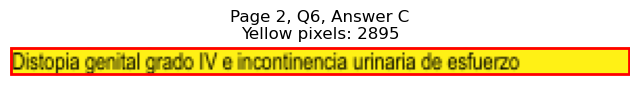

Page 2, Q6 - D: Detected box: x0=68.8, y0=506.0, x1=257.4, y1=518.6
Page 2, Q6, D: Yellow pixels: 231
Page 2, Q6, D: Total non-white pixels: 1226
Page 2, Q6, D: Yellow percentage: 18.8%


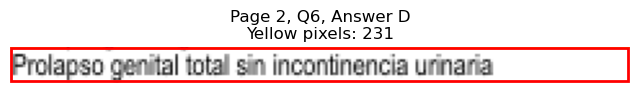


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=133.5, y1=581.8
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 437
Page 2, Q7, A: Yellow percentage: 0.0%


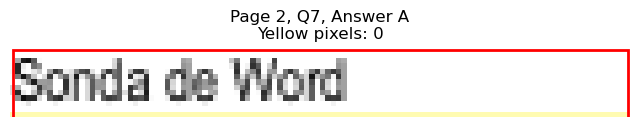

Page 2, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=124.0, y1=594.4
Page 2, Q7, B: Yellow pixels: 1056
Page 2, Q7, B: Total non-white pixels: 1484
Page 2, Q7, B: Yellow percentage: 71.2%


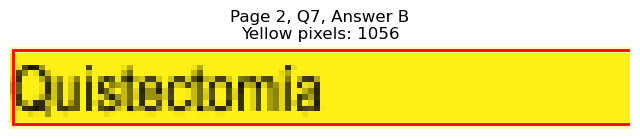

Page 2, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=381.2, y1=581.8
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 286
Page 2, Q7, C: Yellow percentage: 0.0%


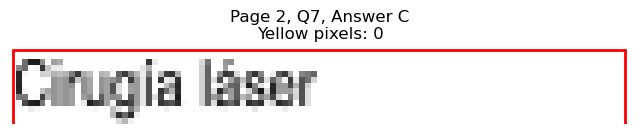

Page 2, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=426.3, y1=594.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 542
Page 2, Q7, D: Yellow percentage: 0.0%


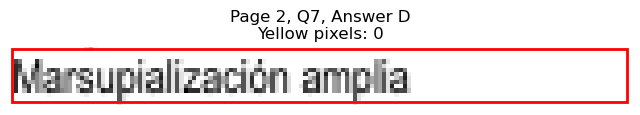


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=147.0, y1=657.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 435
Page 2, Q8, A: Yellow percentage: 0.0%


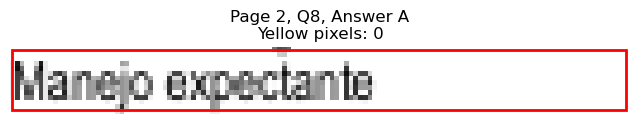

Page 2, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=164.7, y1=670.1
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 488
Page 2, Q8, B: Yellow percentage: 0.0%


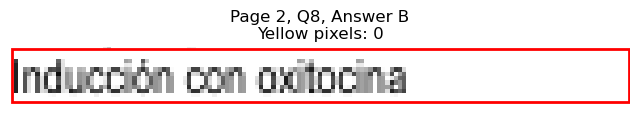

Page 2, Q8 - C: Detected box: x0=327.5, y0=644.9, x1=426.3, y1=657.5
Page 2, Q8, C: Yellow pixels: 150
Page 2, Q8, C: Total non-white pixels: 655
Page 2, Q8, C: Yellow percentage: 22.9%


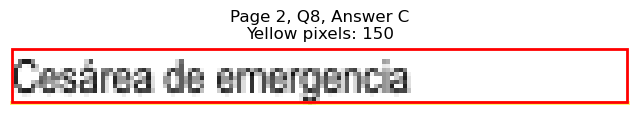

Page 2, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=410.3, y1=670.1
Page 2, Q8, D: Yellow pixels: 1410
Page 2, Q8, D: Total non-white pixels: 1876
Page 2, Q8, D: Yellow percentage: 75.2%


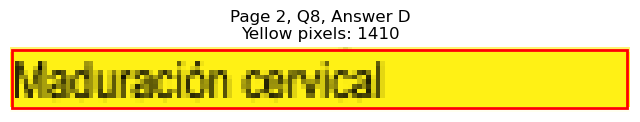


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=720.6, x1=120.0, y1=733.2
Page 2, Q9, A: Yellow pixels: 1144
Page 2, Q9, A: Total non-white pixels: 1442
Page 2, Q9, A: Yellow percentage: 79.3%


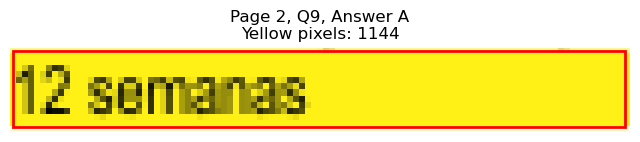

Page 2, Q9 - B: Detected box: x0=68.3, y0=733.2, x1=110.4, y1=745.8
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 280
Page 2, Q9, B: Yellow percentage: 0.0%


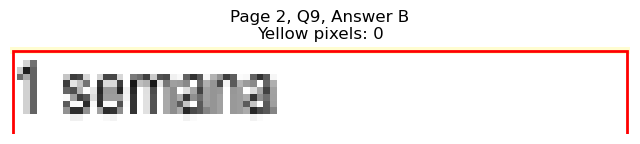

Page 2, Q9 - C: Detected box: x0=327.5, y0=720.6, x1=365.2, y1=733.2
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 170
Page 2, Q9, C: Yellow percentage: 0.0%


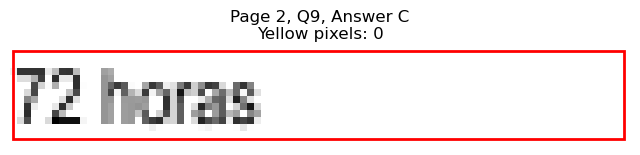

Page 2, Q9 - D: Detected box: x0=327.5, y0=733.2, x1=352.2, y1=745.8
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 101
Page 2, Q9, D: Yellow percentage: 0.0%


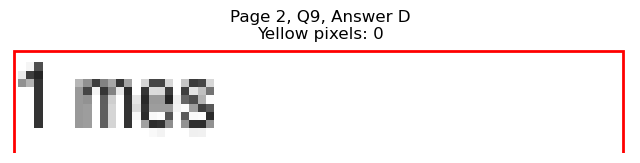


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=151.6, y1=114.7
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 420
Page 3, Q1, A: Yellow percentage: 0.0%


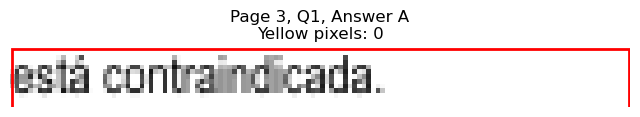

Page 3, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=196.2, y1=127.3
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 569
Page 3, Q1, B: Yellow percentage: 0.0%


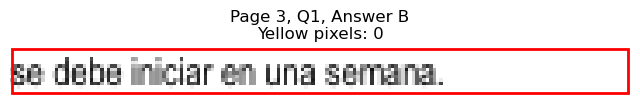

Page 3, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=446.5, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 745
Page 3, Q1, C: Yellow percentage: 0.0%


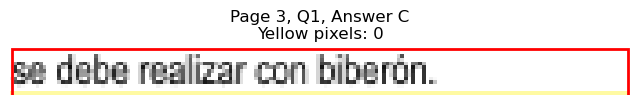

Page 3, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=423.3, y1=127.3
Page 3, Q1, D: Yellow pixels: 1427
Page 3, Q1, D: Total non-white pixels: 2058
Page 3, Q1, D: Yellow percentage: 69.3%


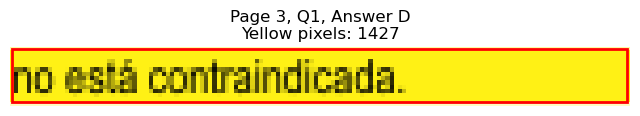


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=148.0, y1=190.4
Page 3, Q2, A: Yellow pixels: 1254
Page 3, Q2, A: Total non-white pixels: 1820
Page 3, Q2, A: Yellow percentage: 68.9%


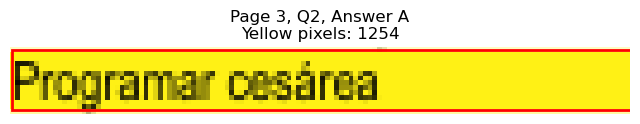

Page 3, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=162.1, y1=203.0
Page 3, Q2, B: Yellow pixels: 2
Page 3, Q2, B: Total non-white pixels: 562
Page 3, Q2, B: Yellow percentage: 0.4%


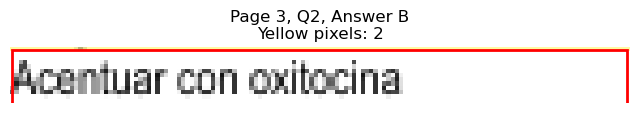

Page 3, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=441.9, y1=190.4
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 598
Page 3, Q2, C: Yellow percentage: 0.0%


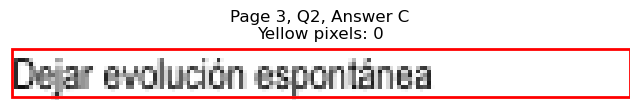

Page 3, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=419.8, y1=203.0
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 461
Page 3, Q2, D: Yellow percentage: 0.0%


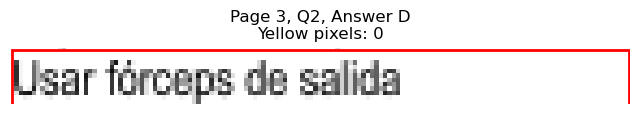


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=171.1, y1=253.5
Page 3, Q3, A: Yellow pixels: 154
Page 3, Q3, A: Total non-white pixels: 668
Page 3, Q3, A: Yellow percentage: 23.1%


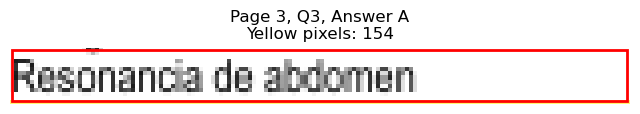

Page 3, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=134.5, y1=266.1
Page 3, Q3, B: Yellow pixels: 1284
Page 3, Q3, B: Total non-white pixels: 1638
Page 3, Q3, B: Yellow percentage: 78.4%


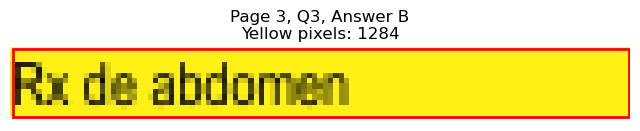

Page 3, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=380.7, y1=253.5
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 261
Page 3, Q3, C: Yellow percentage: 0.0%


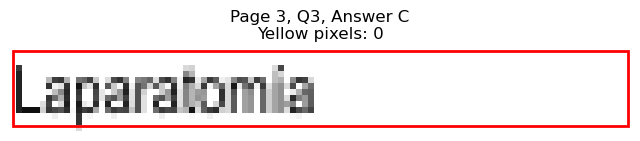

Page 3, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=423.3, y1=266.1
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 459
Page 3, Q3, D: Yellow percentage: 0.0%


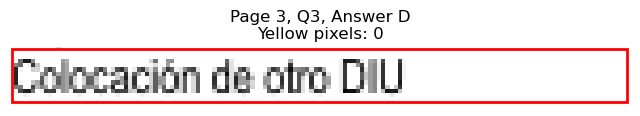


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=176.7, y1=329.3
Page 3, Q4, A: Yellow pixels: 159
Page 3, Q4, A: Total non-white pixels: 734
Page 3, Q4, A: Yellow percentage: 21.7%


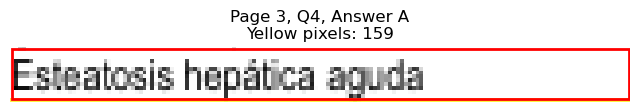

Page 3, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=214.7, y1=341.9
Page 3, Q4, B: Yellow pixels: 1948
Page 3, Q4, B: Total non-white pixels: 2561
Page 3, Q4, B: Yellow percentage: 76.1%


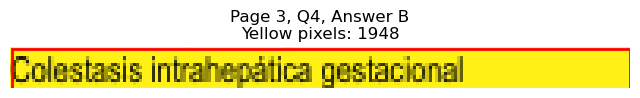

Page 3, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=392.7, y1=329.3
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 364
Page 3, Q4, C: Yellow percentage: 0.0%


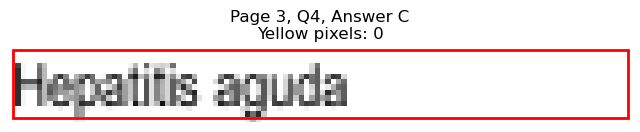

Page 3, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=444.9, y1=341.9
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 613
Page 3, Q4, D: Yellow percentage: 0.0%


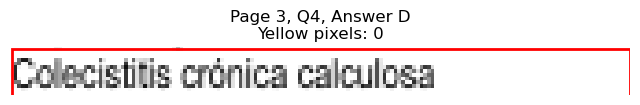


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=121.5, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 287
Page 3, Q5, A: Yellow percentage: 0.0%


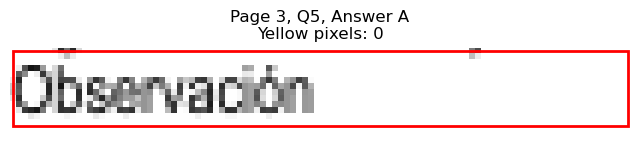

Page 3, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=119.4, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 284
Page 3, Q5, B: Yellow percentage: 0.0%


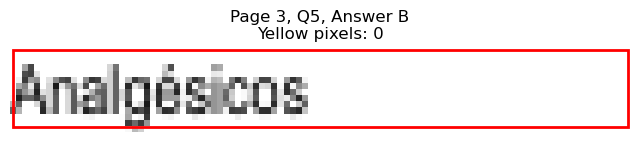

Page 3, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=367.6, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 202
Page 3, Q5, C: Yellow percentage: 0.0%


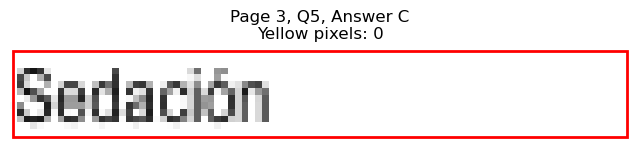

Page 3, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=380.7, y1=430.3
Page 3, Q5, D: Yellow pixels: 1048
Page 3, Q5, D: Total non-white pixels: 1456
Page 3, Q5, D: Yellow percentage: 72.0%


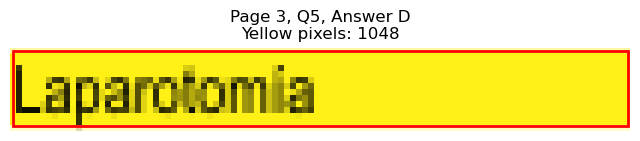


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=197.2, y1=480.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 674
Page 3, Q6, A: Yellow percentage: 0.0%


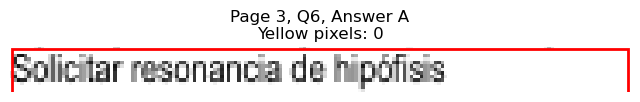

Page 3, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=132.0, y1=493.4
Page 3, Q6, B: Yellow pixels: 1146
Page 3, Q6, B: Total non-white pixels: 1610
Page 3, Q6, B: Yellow percentage: 71.2%


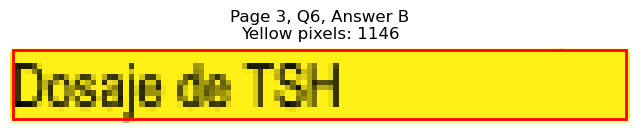

Page 3, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=455.5, y1=480.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 651
Page 3, Q6, C: Yellow percentage: 0.0%


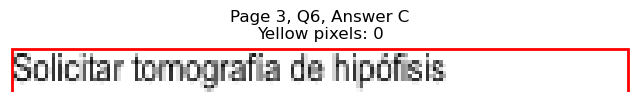

Page 3, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=452.5, y1=493.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 618
Page 3, Q6, D: Yellow percentage: 0.0%


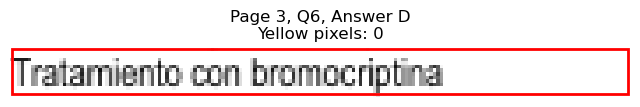


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=243.3, y1=531.2
Page 3, Q7, A: Yellow pixels: 226
Page 3, Q7, A: Total non-white pixels: 1073
Page 3, Q7, A: Yellow percentage: 21.1%


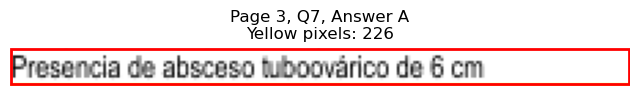

Page 3, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=293.4, y1=543.8
Page 3, Q7, B: Yellow pixels: 2755
Page 3, Q7, B: Total non-white pixels: 3588
Page 3, Q7, B: Yellow percentage: 76.8%


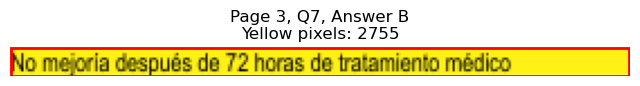

Page 3, Q7 - C: Detected box: x0=68.8, y0=543.8, x1=262.5, y1=556.4
Page 3, Q7, C: Yellow pixels: 241
Page 3, Q7, C: Total non-white pixels: 1174
Page 3, Q7, C: Yellow percentage: 20.5%


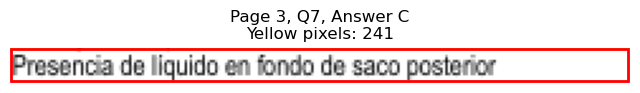

Page 3, Q7 - D: Detected box: x0=68.8, y0=556.5, x1=194.2, y1=569.2
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 629
Page 3, Q7, D: Yellow percentage: 0.0%


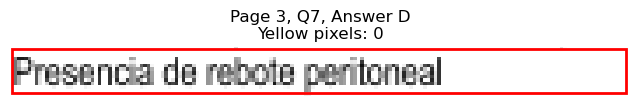


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=171.1, y1=644.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 684
Page 3, Q8, A: Yellow percentage: 0.0%


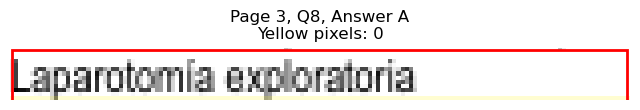

Page 3, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=282.4, y1=657.5
Page 3, Q8, B: Yellow pixels: 1930
Page 3, Q8, B: Total non-white pixels: 3063
Page 3, Q8, B: Yellow percentage: 63.0%


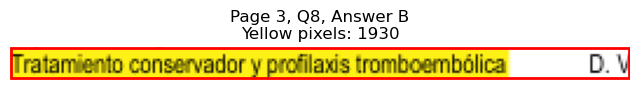

Page 3, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=462.1, y1=644.9
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 676
Page 3, Q8, C: Yellow percentage: 0.0%


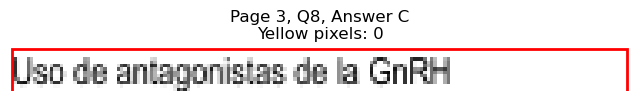

Page 3, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=446.9, y1=657.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 644
Page 3, Q8, D: Yellow percentage: 0.0%


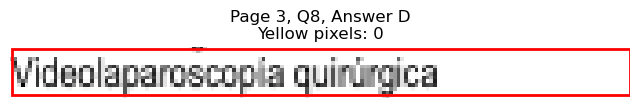


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=223.4, y1=695.3
Page 3, Q9, A: Yellow pixels: 1876
Page 3, Q9, A: Total non-white pixels: 2884
Page 3, Q9, A: Yellow percentage: 65.0%


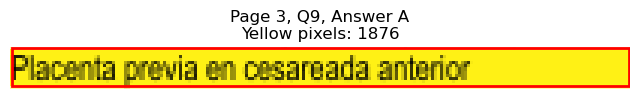

Page 3, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=178.1, y1=708.0
Page 3, Q9, B: Yellow pixels: 1
Page 3, Q9, B: Total non-white pixels: 737
Page 3, Q9, B: Yellow percentage: 0.1%


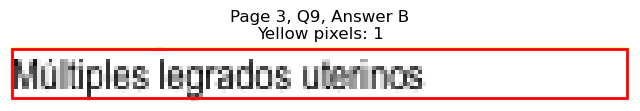

Page 3, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=454.5, y1=695.3
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 644
Page 3, Q9, C: Yellow percentage: 0.0%


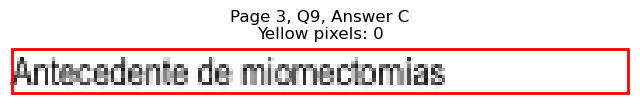

Page 3, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=414.3, y1=708.0
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 439
Page 3, Q9, D: Yellow percentage: 0.0%


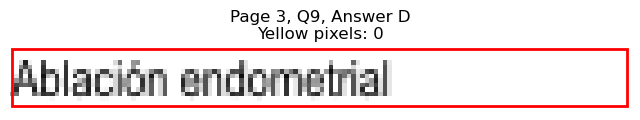


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=198.3, y1=127.3
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 665
Page 4, Q1, A: Yellow percentage: 0.0%


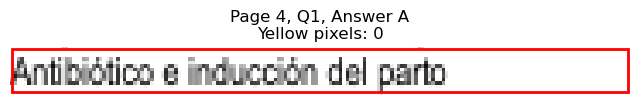

Page 4, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=229.4, y1=139.9
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 755
Page 4, Q1, B: Yellow percentage: 0.0%


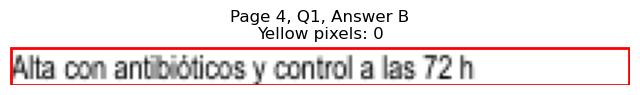

Page 4, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=503.1, y1=127.3
Page 4, Q1, C: Yellow pixels: 1837
Page 4, Q1, C: Total non-white pixels: 2996
Page 4, Q1, C: Yellow percentage: 61.3%


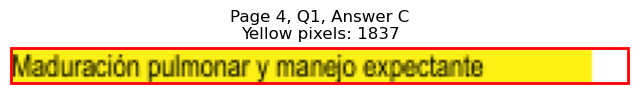

Page 4, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=432.3, y1=139.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 702
Page 4, Q1, D: Yellow percentage: 0.0%


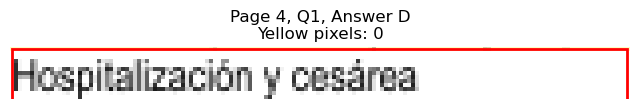


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=226.2, y1=190.4
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 719
Page 4, Q2, A: Yellow percentage: 0.0%


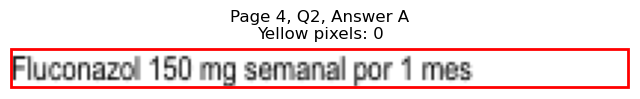

Page 4, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=290.4, y1=203.0
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 1316
Page 4, Q2, B: Yellow percentage: 0.0%


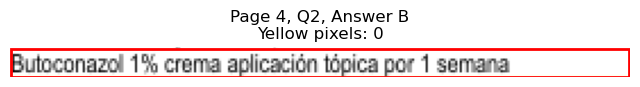

Page 4, Q2 - C: Detected box: x0=68.8, y0=202.9, x1=367.1, y1=215.6
Page 4, Q2, C: Yellow pixels: 3430
Page 4, Q2, C: Total non-white pixels: 4900
Page 4, Q2, C: Yellow percentage: 70.0%


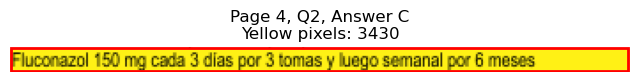

Page 4, Q2 - D: Detected box: x0=68.8, y0=215.7, x1=239.8, y1=228.3
Page 4, Q2, D: Yellow pixels: 218
Page 4, Q2, D: Total non-white pixels: 984
Page 4, Q2, D: Yellow percentage: 22.2%


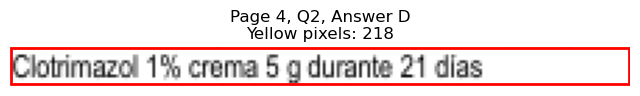


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=120.0, y1=266.1
Page 4, Q3, A: Yellow pixels: 1167
Page 4, Q3, A: Total non-white pixels: 1442
Page 4, Q3, A: Yellow percentage: 80.9%


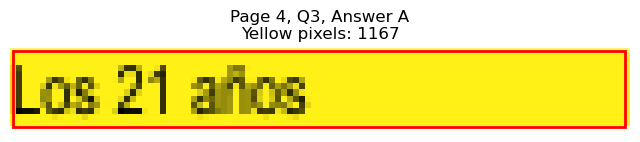

Page 4, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=120.0, y1=278.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 329
Page 4, Q3, B: Yellow percentage: 0.0%


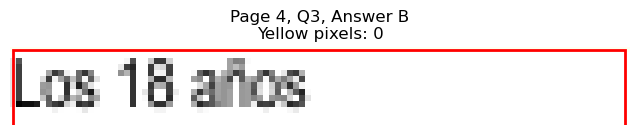

Page 4, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=445.4, y1=266.1
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 587
Page 4, Q3, C: Yellow percentage: 0.0%


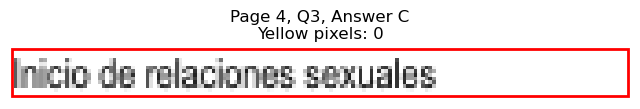

Page 4, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=379.3, y1=278.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 233
Page 4, Q3, D: Yellow percentage: 0.0%


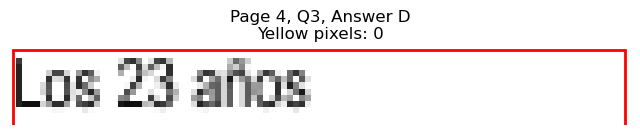


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=65.2, y1=329.3
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 88
Page 4, Q4, A: Yellow percentage: 0.0%


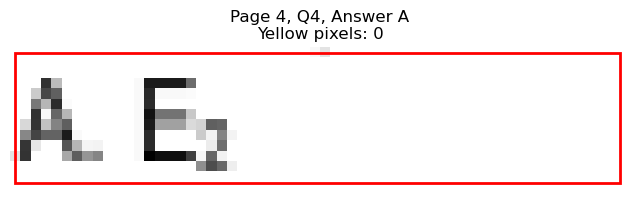

Page 4, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=65.2, y1=341.9
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 97
Page 4, Q4, B: Yellow percentage: 0.0%


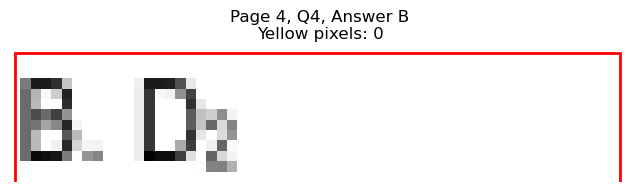

Page 4, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=324.4, y1=329.3
Page 4, Q4, C: Yellow pixels: 651
Page 4, Q4, C: Total non-white pixels: 840
Page 4, Q4, C: Yellow percentage: 77.5%


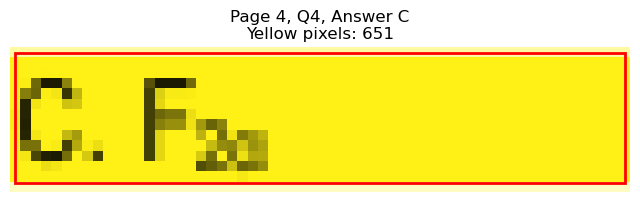

Page 4, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=324.4, y1=341.9
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 141
Page 4, Q4, D: Yellow percentage: 0.0%


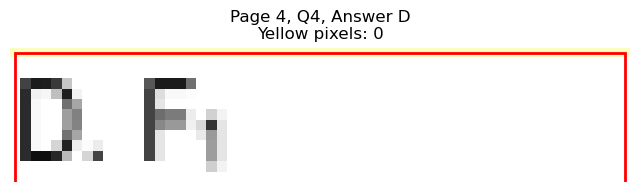


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=156.0, y1=417.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 435
Page 4, Q5, A: Yellow percentage: 0.0%


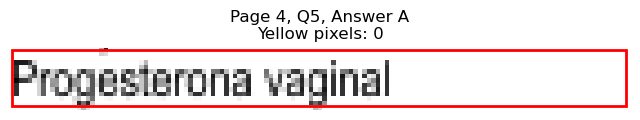

Page 4, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=149.5, y1=430.3
Page 4, Q5, B: Yellow pixels: 1266
Page 4, Q5, B: Total non-white pixels: 1848
Page 4, Q5, B: Yellow percentage: 68.5%


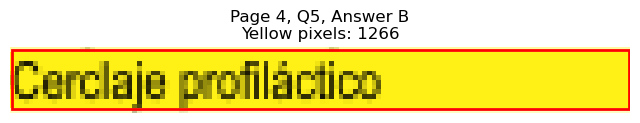

Page 4, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=430.4, y1=417.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 518
Page 4, Q5, C: Yellow percentage: 0.0%


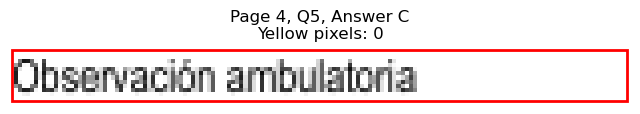

Page 4, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=422.8, y1=430.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 465
Page 4, Q5, D: Yellow percentage: 0.0%


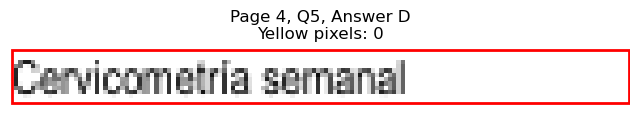


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=141.0, y1=493.4
Page 4, Q6, A: Yellow pixels: 1203
Page 4, Q6, A: Total non-white pixels: 1736
Page 4, Q6, A: Yellow percentage: 69.3%


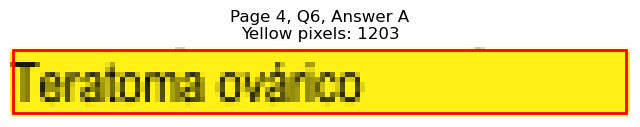

Page 4, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=205.7, y1=506.0
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 885
Page 4, Q6, B: Yellow percentage: 0.0%


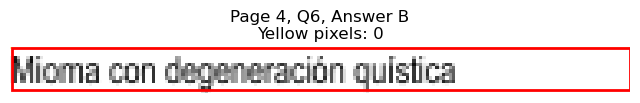

Page 4, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=420.3, y1=493.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 443
Page 4, Q6, C: Yellow percentage: 0.0%


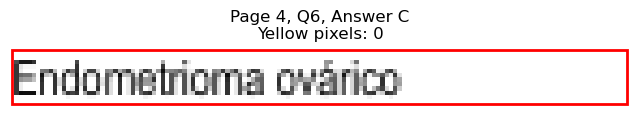

Page 4, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=390.3, y1=506.0
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 328
Page 4, Q6, D: Yellow percentage: 0.0%


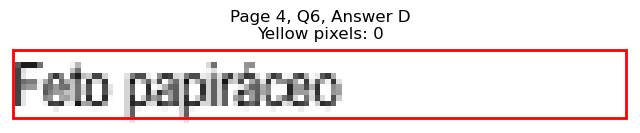


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=65.2, y1=556.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 81
Page 4, Q7, A: Yellow percentage: 0.0%


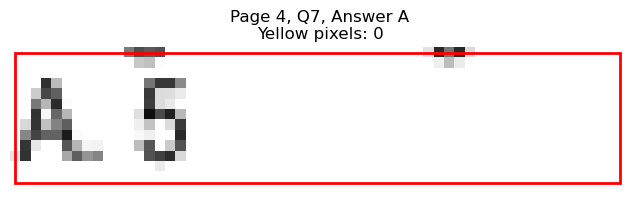

Page 4, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=65.2, y1=569.2
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 66
Page 4, Q7, B: Yellow percentage: 0.0%


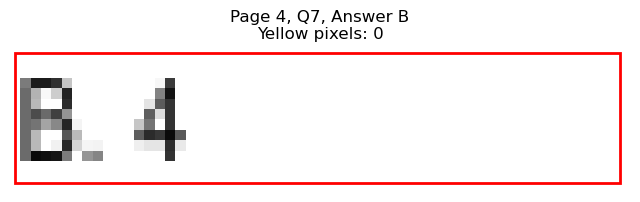

Page 4, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=369.7, y1=556.4
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 206
Page 4, Q7, C: Yellow percentage: 0.0%


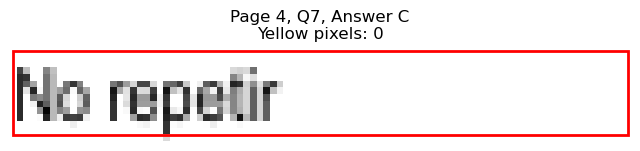

Page 4, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=324.4, y1=569.2
Page 4, Q7, D: Yellow pixels: 729
Page 4, Q7, D: Total non-white pixels: 840
Page 4, Q7, D: Yellow percentage: 86.8%


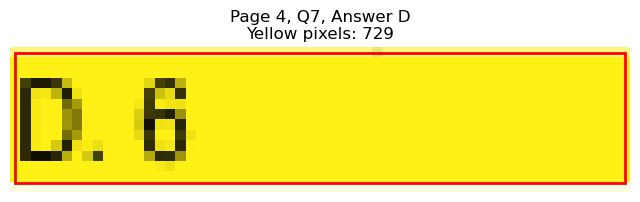


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=113.9, y1=619.6
Page 4, Q8, A: Yellow pixels: 1073
Page 4, Q8, A: Total non-white pixels: 1344
Page 4, Q8, A: Yellow percentage: 79.8%


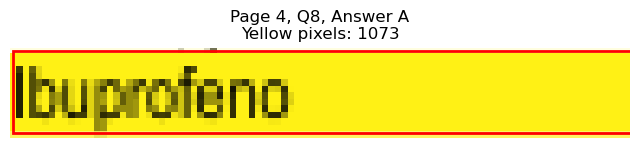

Page 4, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=131.5, y1=632.3
Page 4, Q8, B: Yellow pixels: 114
Page 4, Q8, B: Total non-white pixels: 460
Page 4, Q8, B: Yellow percentage: 24.8%


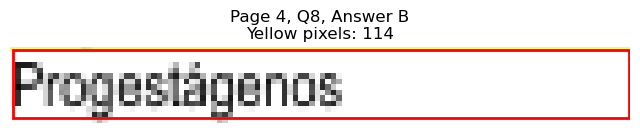

Page 4, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=380.7, y1=619.6
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 265
Page 4, Q8, C: Yellow percentage: 0.0%


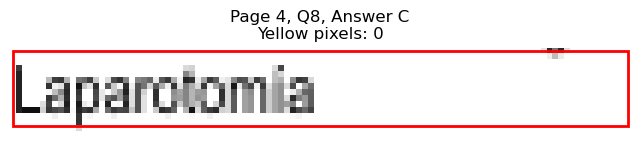

Page 4, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=380.7, y1=632.3
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 264
Page 4, Q8, D: Yellow percentage: 0.0%


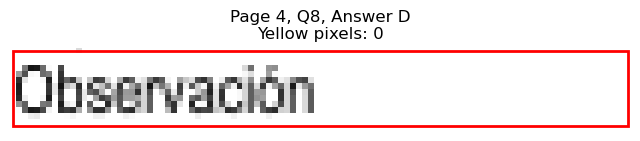


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=146.1, y1=682.7
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 515
Page 4, Q9, A: Yellow percentage: 0.0%


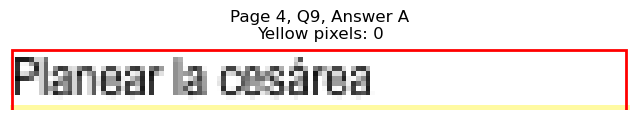

Page 4, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=208.7, y1=695.3
Page 4, Q9, B: Yellow pixels: 1770
Page 4, Q9, B: Total non-white pixels: 2674
Page 4, Q9, B: Yellow percentage: 66.2%


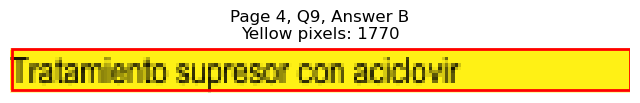

Page 4, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=425.3, y1=682.7
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 499
Page 4, Q9, C: Yellow percentage: 0.0%


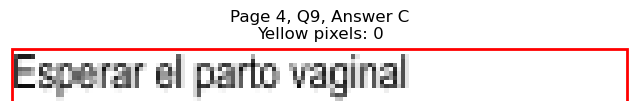

Page 4, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=389.7, y1=695.3
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 319
Page 4, Q9, D: Yellow percentage: 0.0%


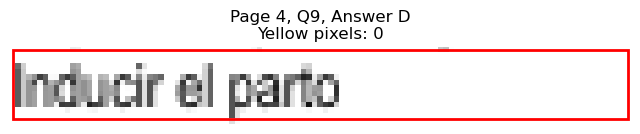


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=170.1, y1=733.2
Page 4, Q10, A: Yellow pixels: 153
Page 4, Q10, A: Total non-white pixels: 661
Page 4, Q10, A: Yellow percentage: 23.1%


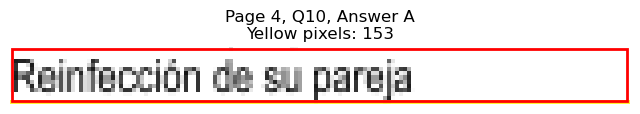

Page 4, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=229.7, y1=745.8
Page 4, Q10, B: Yellow pixels: 2117
Page 4, Q10, B: Total non-white pixels: 2756
Page 4, Q10, B: Yellow percentage: 76.8%


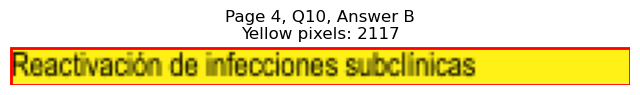

Page 4, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=427.4, y1=733.2
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 516
Page 4, Q10, C: Yellow percentage: 0.0%


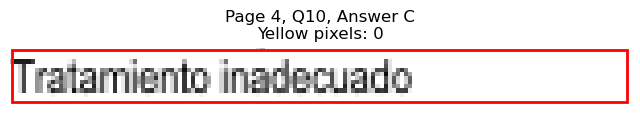

Page 4, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=390.8, y1=745.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 336
Page 4, Q10, D: Yellow percentage: 0.0%


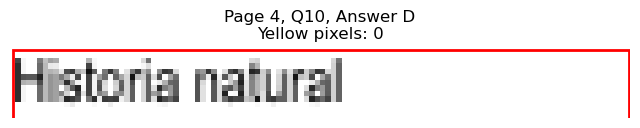


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=135.5, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 316
Page 5, Q1, A: Yellow percentage: 0.0%


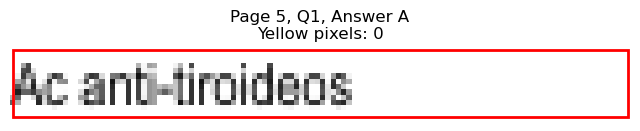

Page 5, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=150.6, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 428
Page 5, Q1, B: Yellow percentage: 0.0%


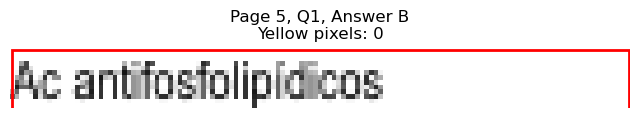

Page 5, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=411.3, y1=127.3
Page 5, Q1, C: Yellow pixels: 135
Page 5, Q1, C: Total non-white pixels: 553
Page 5, Q1, C: Yellow percentage: 24.4%


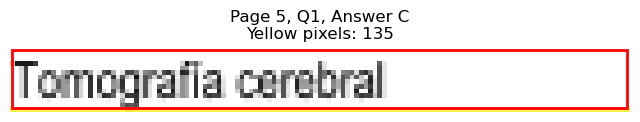

Page 5, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=366.2, y1=139.9
Page 5, Q1, D: Yellow pixels: 1009
Page 5, Q1, D: Total non-white pixels: 1170
Page 5, Q1, D: Yellow percentage: 86.2%


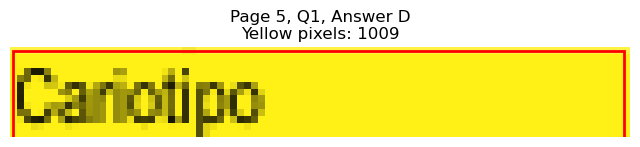


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=206.2, y1=203.0
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 637
Page 5, Q2, A: Yellow percentage: 0.0%


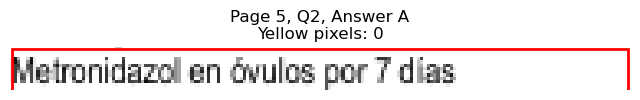

Page 5, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=190.7, y1=215.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 582
Page 5, Q2, B: Yellow percentage: 0.0%


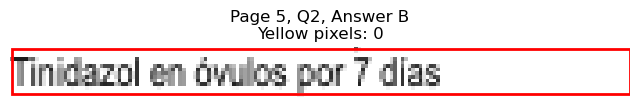

Page 5, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=476.6, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 931
Page 5, Q2, C: Yellow percentage: 0.0%


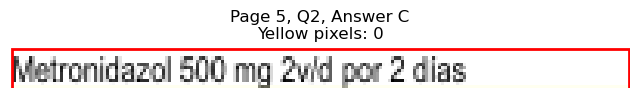

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=475.1, y1=215.6
Page 5, Q2, D: Yellow pixels: 2035
Page 5, Q2, D: Total non-white pixels: 2786
Page 5, Q2, D: Yellow percentage: 73.0%


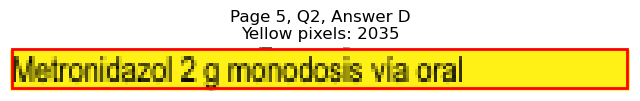


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=229.8, y1=291.5
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 771
Page 5, Q3, A: Yellow percentage: 0.0%


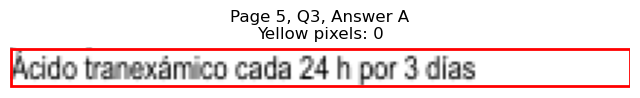

Page 5, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=190.2, y1=304.1
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 632
Page 5, Q3, B: Yellow percentage: 0.0%


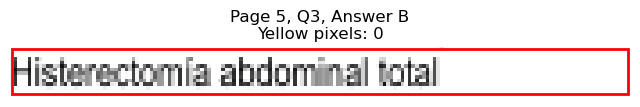

Page 5, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=454.5, y1=291.5
Page 5, Q3, C: Yellow pixels: 178
Page 5, Q3, C: Total non-white pixels: 817
Page 5, Q3, C: Yellow percentage: 21.8%


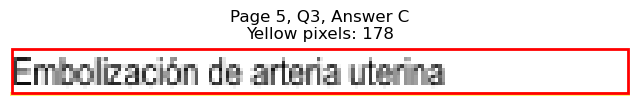

Page 5, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=529.3, y1=304.1
Page 5, Q3, D: Yellow pixels: 2046
Page 5, Q3, D: Total non-white pixels: 2995
Page 5, Q3, D: Yellow percentage: 68.3%


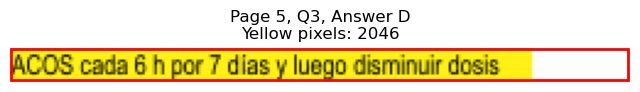


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=116.9, y1=367.2
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 245
Page 5, Q4, A: Yellow percentage: 0.0%


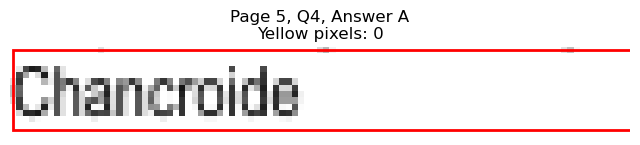

Page 5, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=99.9, y1=379.8
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 165
Page 5, Q4, B: Yellow percentage: 0.0%


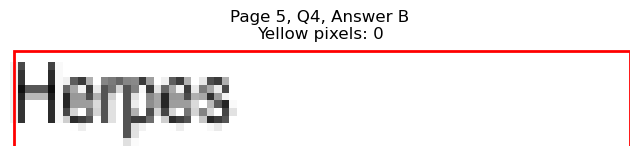

Page 5, Q4 - C: Detected box: x0=327.5, y0=354.5, x1=382.3, y1=367.2
Page 5, Q4, C: Yellow pixels: 106
Page 5, Q4, C: Total non-white pixels: 383
Page 5, Q4, C: Yellow percentage: 27.7%


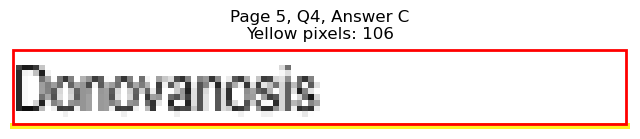

Page 5, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=351.7, y1=379.8
Page 5, Q4, D: Yellow pixels: 875
Page 5, Q4, D: Total non-white pixels: 975
Page 5, Q4, D: Yellow percentage: 89.7%


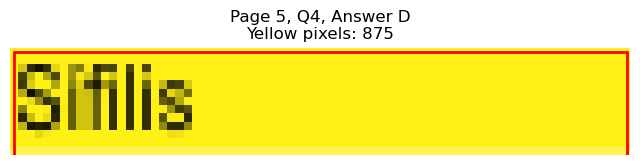


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=144.5, y1=430.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 381
Page 5, Q5, A: Yellow percentage: 0.0%


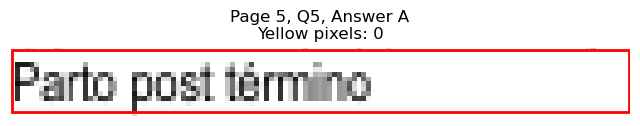

Page 5, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=140.1, y1=442.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 368
Page 5, Q5, B: Yellow percentage: 0.0%


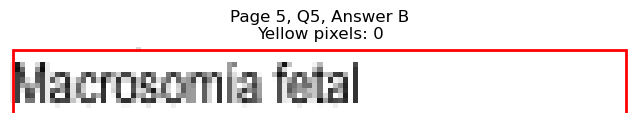

Page 5, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=441.4, y1=430.3
Page 5, Q5, C: Yellow pixels: 1550
Page 5, Q5, C: Total non-white pixels: 2310
Page 5, Q5, C: Yellow percentage: 67.1%


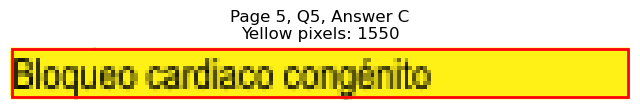

Page 5, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=377.7, y1=442.9
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 383
Page 5, Q5, D: Yellow percentage: 0.0%


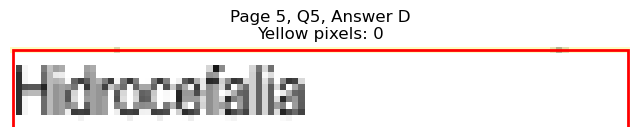


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=127.0, y1=518.6
Page 5, Q6, A: Yellow pixels: 1203
Page 5, Q6, A: Total non-white pixels: 1526
Page 5, Q6, A: Yellow percentage: 78.8%


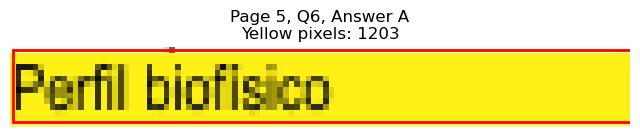

Page 5, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=182.2, y1=531.2
Page 5, Q6, B: Yellow pixels: 165
Page 5, Q6, B: Total non-white pixels: 737
Page 5, Q6, B: Yellow percentage: 22.4%


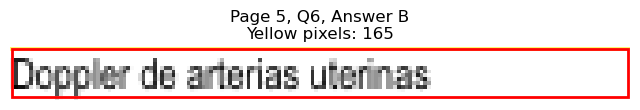

Page 5, Q6 - C: Detected box: x0=327.5, y0=506.0, x1=439.9, y1=518.6
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 585
Page 5, Q6, C: Yellow percentage: 0.0%


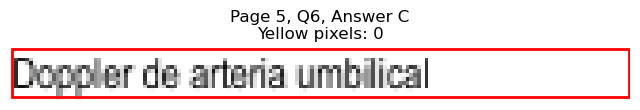

Page 5, Q6 - D: Detected box: x0=327.5, y0=518.6, x1=416.3, y1=531.2
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 419
Page 5, Q6, D: Yellow percentage: 0.0%


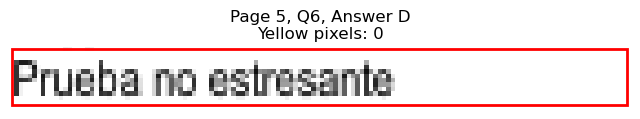


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=266.0, y1=581.8
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 1007
Page 5, Q7, A: Yellow percentage: 0.0%


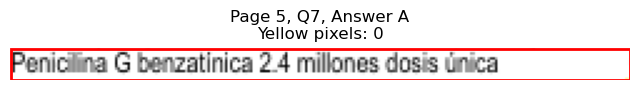

Page 5, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=263.0, y1=594.4
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 904
Page 5, Q7, B: Yellow percentage: 0.0%


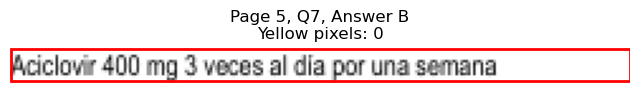

Page 5, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=490.1, y1=581.8
Page 5, Q7, C: Yellow pixels: 2
Page 5, Q7, C: Total non-white pixels: 1014
Page 5, Q7, C: Yellow percentage: 0.2%


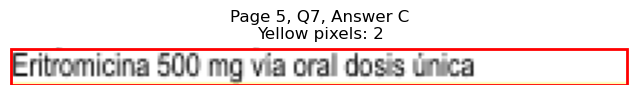

Page 5, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=474.1, y1=594.4
Page 5, Q7, D: Yellow pixels: 1833
Page 5, Q7, D: Total non-white pixels: 2772
Page 5, Q7, D: Yellow percentage: 66.1%


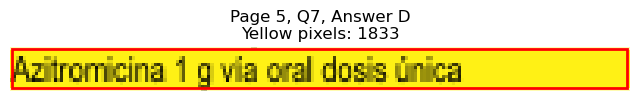


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=197.8, y1=632.3
Page 5, Q8, A: Yellow pixels: 180
Page 5, Q8, A: Total non-white pixels: 801
Page 5, Q8, A: Yellow percentage: 22.5%


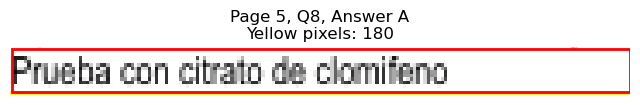

Page 5, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=237.3, y1=644.9
Page 5, Q8, B: Yellow pixels: 2108
Page 5, Q8, B: Total non-white pixels: 2782
Page 5, Q8, B: Yellow percentage: 75.8%


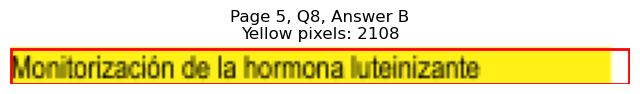

Page 5, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=467.5, y1=632.3
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 729
Page 5, Q8, C: Yellow percentage: 0.0%


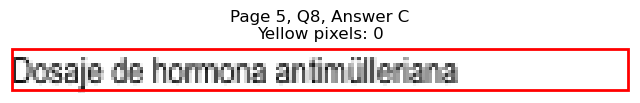

Page 5, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=449.9, y1=644.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 602
Page 5, Q8, D: Yellow percentage: 0.0%


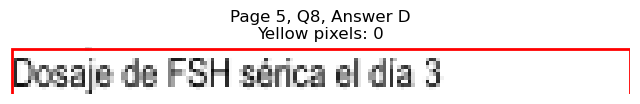


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=197.2, y1=682.7
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 642
Page 5, Q9, A: Yellow percentage: 0.0%


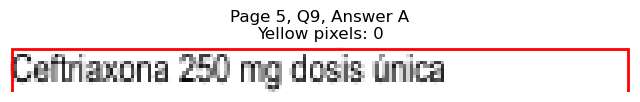

Page 5, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=200.2, y1=695.3
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 661
Page 5, Q9, B: Yellow percentage: 0.0%


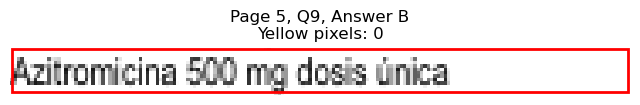

Page 5, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=498.7, y1=682.7
Page 5, Q9, C: Yellow pixels: 5
Page 5, Q9, C: Total non-white pixels: 1005
Page 5, Q9, C: Yellow percentage: 0.5%


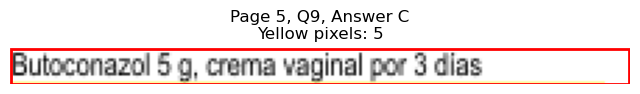

Page 5, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=516.1, y1=695.3
Page 5, Q9, D: Yellow pixels: 1902
Page 5, Q9, D: Total non-white pixels: 2996
Page 5, Q9, D: Yellow percentage: 63.5%


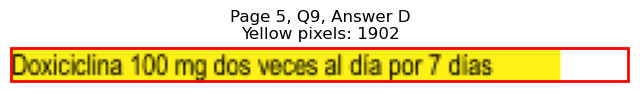


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=159.0, y1=733.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 393
Page 5, Q10, A: Yellow percentage: 0.0%


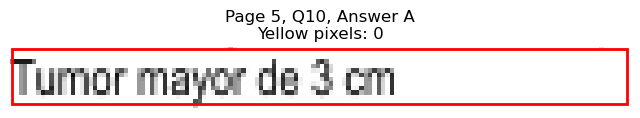

Page 5, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=157.6, y1=745.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 418
Page 5, Q10, B: Yellow percentage: 0.0%


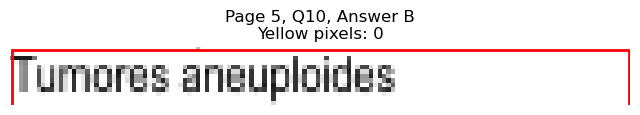

Page 5, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=477.6, y1=733.2
Page 5, Q10, C: Yellow pixels: 2036
Page 5, Q10, C: Total non-white pixels: 2814
Page 5, Q10, C: Yellow percentage: 72.4%


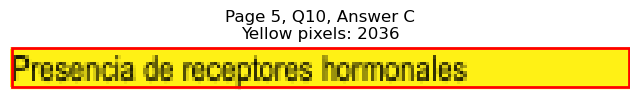

Page 5, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=399.8, y1=745.8
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 484
Page 5, Q10, D: Yellow percentage: 0.0%


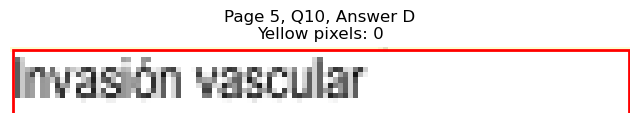


Page 5, Q10 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=83.4, y1=127.3
Page 6, Q1, A: Yellow pixels: 66
Page 6, Q1, A: Total non-white pixels: 134
Page 6, Q1, A: Yellow percentage: 49.3%


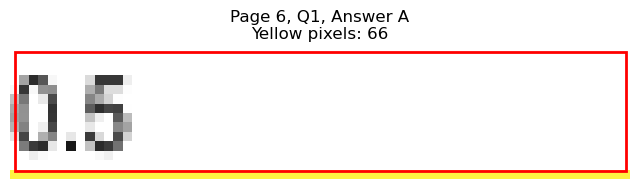

Page 6, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=65.2, y1=139.9
Page 6, Q1, B: Yellow pixels: 722
Page 6, Q1, B: Total non-white pixels: 780
Page 6, Q1, B: Yellow percentage: 92.6%


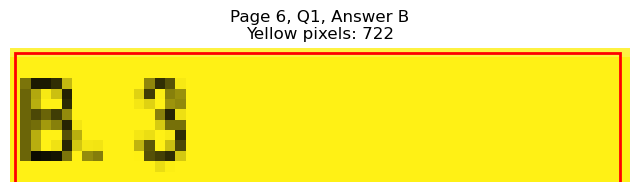

Page 6, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=324.4, y1=127.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 62
Page 6, Q1, C: Yellow percentage: 0.0%


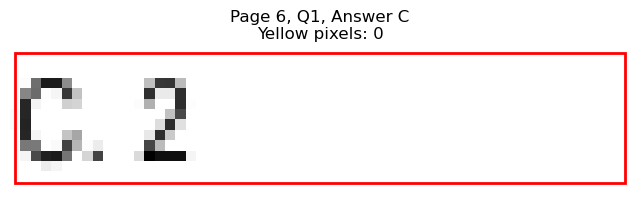

Page 6, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=324.4, y1=139.9
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 53
Page 6, Q1, D: Yellow percentage: 0.0%


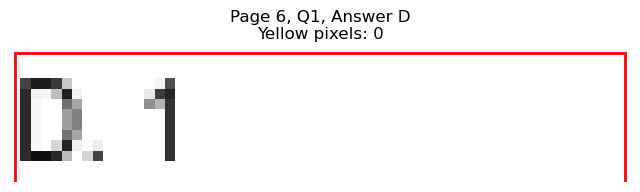


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=143.1, y1=190.4
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 375
Page 6, Q2, A: Yellow percentage: 0.0%


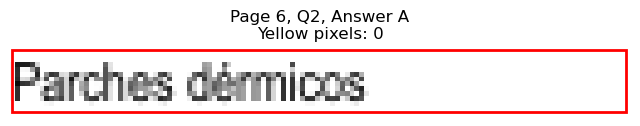

Page 6, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=124.0, y1=203.0
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 267
Page 6, Q2, B: Yellow percentage: 0.0%


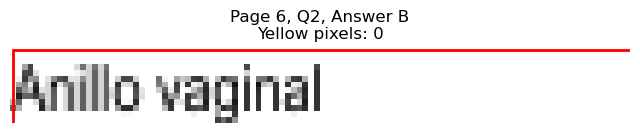

Page 6, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=447.9, y1=190.4
Page 6, Q2, C: Yellow pixels: 1576
Page 6, Q2, C: Total non-white pixels: 2394
Page 6, Q2, C: Yellow percentage: 65.8%


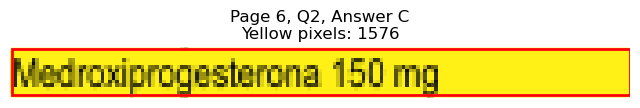

Page 6, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=471.5, y1=203.0
Page 6, Q2, D: Yellow pixels: 2
Page 6, Q2, D: Total non-white pixels: 915
Page 6, Q2, D: Yellow percentage: 0.2%


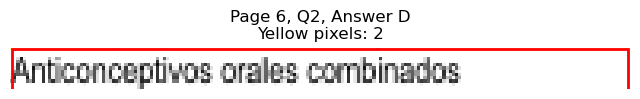


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=89.9, y1=253.5
Page 6, Q3, A: Yellow pixels: 855
Page 6, Q3, A: Total non-white pixels: 1008
Page 6, Q3, A: Yellow percentage: 84.8%


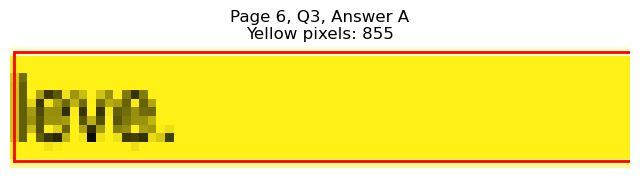

Page 6, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=113.9, y1=266.1
Page 6, Q3, B: Yellow pixels: 96
Page 6, Q3, B: Total non-white pixels: 323
Page 6, Q3, B: Yellow percentage: 29.7%


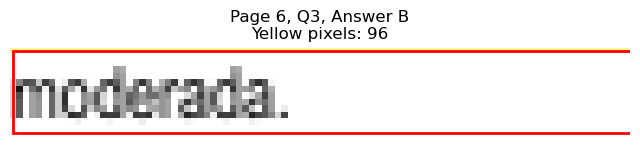

Page 6, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=355.1, y1=253.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 120
Page 6, Q3, C: Yellow percentage: 0.0%


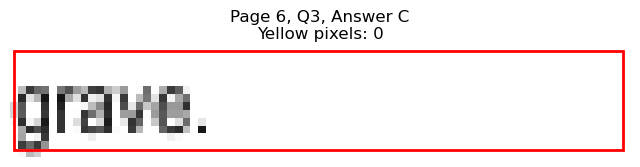

Page 6, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=359.7, y1=266.1
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 150
Page 6, Q3, D: Yellow percentage: 0.0%


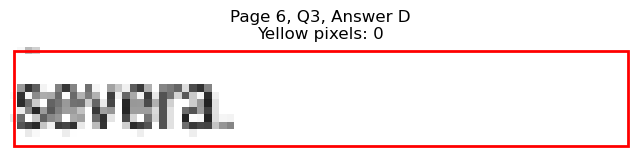


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=350.7, y1=304.1
Page 6, Q4, A: Yellow pixels: 3277
Page 6, Q4, A: Total non-white pixels: 4662
Page 6, Q4, A: Yellow percentage: 70.3%


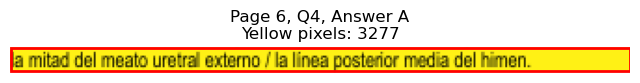

Page 6, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=301.5, y1=316.7
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 1397
Page 6, Q4, B: Yellow percentage: 0.0%


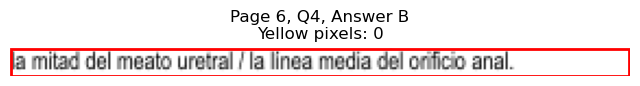

Page 6, Q4 - C: Detected box: x0=68.8, y0=316.6, x1=363.3, y1=329.3
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 1393
Page 6, Q4, C: Yellow percentage: 0.0%


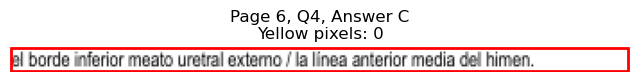

Page 6, Q4 - D: Detected box: x0=68.8, y0=329.2, x1=311.6, y1=341.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 1159
Page 6, Q4, D: Yellow percentage: 0.0%


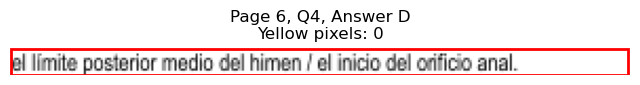


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=65.2, y1=405.0
Page 6, Q5, A: Yellow pixels: 731
Page 6, Q5, A: Total non-white pixels: 780
Page 6, Q5, A: Yellow percentage: 93.7%


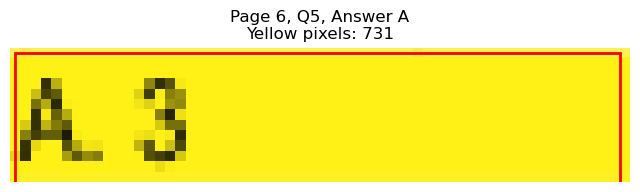

Page 6, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=65.2, y1=417.6
Page 6, Q5, B: Yellow pixels: 60
Page 6, Q5, B: Total non-white pixels: 120
Page 6, Q5, B: Yellow percentage: 50.0%


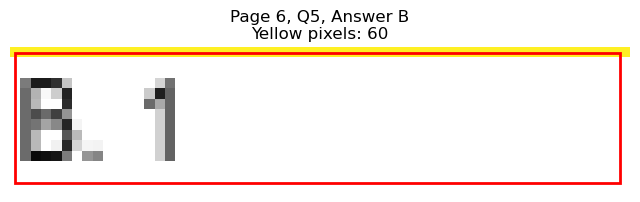

Page 6, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=324.4, y1=405.0
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 67
Page 6, Q5, C: Yellow percentage: 0.0%


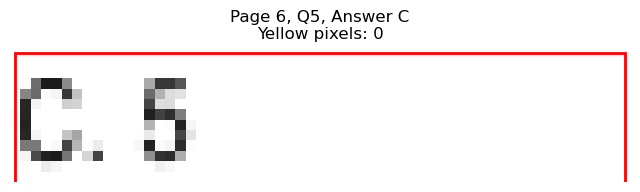

Page 6, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=340.1, y1=417.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 44
Page 6, Q5, D: Yellow percentage: 0.0%


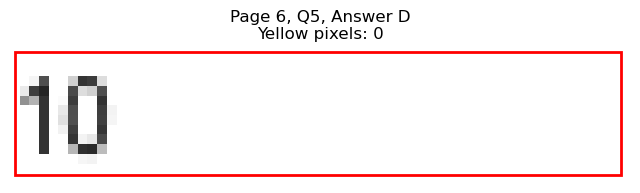


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=168.4, y1=468.1
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 459
Page 6, Q6, A: Yellow percentage: 0.0%


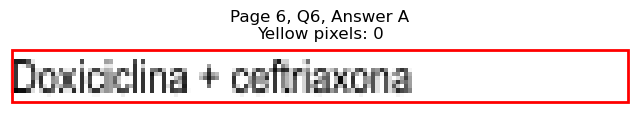

Page 6, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=174.4, y1=480.7
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 495
Page 6, Q6, B: Yellow percentage: 0.0%


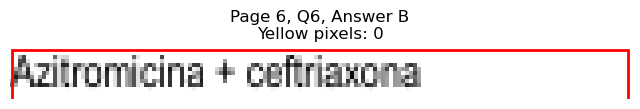

Page 6, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=489.6, y1=468.1
Page 6, Q6, C: Yellow pixels: 2190
Page 6, Q6, C: Total non-white pixels: 2982
Page 6, Q6, C: Yellow percentage: 73.4%


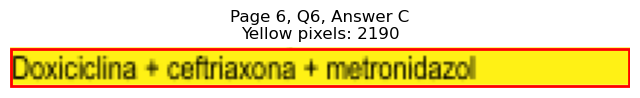

Page 6, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=435.2, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 688
Page 6, Q6, D: Yellow percentage: 0.0%


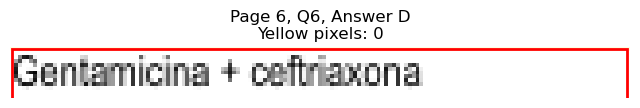


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=279.9, y1=531.2
Page 6, Q7, A: Yellow pixels: 16
Page 6, Q7, A: Total non-white pixels: 1143
Page 6, Q7, A: Yellow percentage: 1.4%


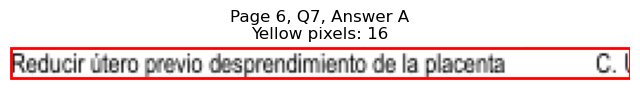

Page 6, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=233.3, y1=543.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 849
Page 6, Q7, B: Yellow percentage: 0.0%


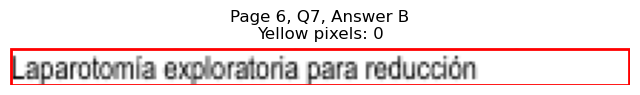

Page 6, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=493.1, y1=531.2
Page 6, Q7, C: Yellow pixels: 213
Page 6, Q7, C: Total non-white pixels: 1040
Page 6, Q7, C: Yellow percentage: 20.5%


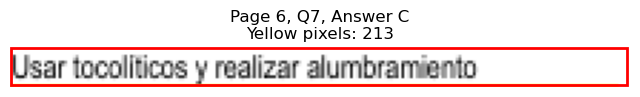

Page 6, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=475.5, y1=543.8
Page 6, Q7, D: Yellow pixels: 1981
Page 6, Q7, D: Total non-white pixels: 2587
Page 6, Q7, D: Yellow percentage: 76.6%


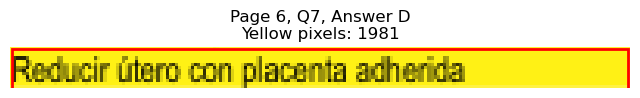


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=210.3, y1=607.0
Page 6, Q8, A: Yellow pixels: 1929
Page 6, Q8, A: Total non-white pixels: 2509
Page 6, Q8, A: Yellow percentage: 76.9%


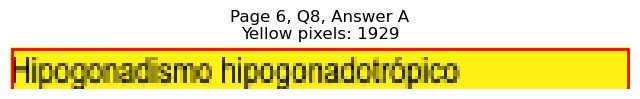

Page 6, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=195.7, y1=619.6
Page 6, Q8, B: Yellow pixels: 166
Page 6, Q8, B: Total non-white pixels: 826
Page 6, Q8, B: Yellow percentage: 20.1%


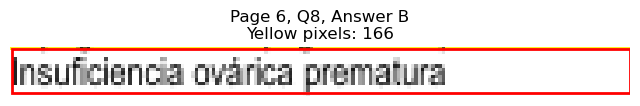

Page 6, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=409.4, y1=607.0
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 440
Page 6, Q8, C: Yellow percentage: 0.0%


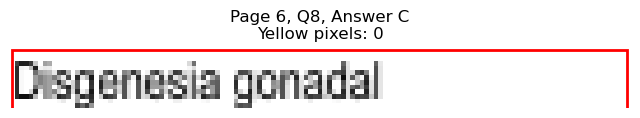

Page 6, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=477.6, y1=619.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 768
Page 6, Q8, D: Yellow percentage: 0.0%


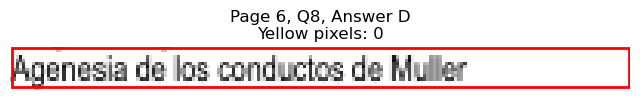


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=147.0, y1=682.7
Page 6, Q9, A: Yellow pixels: 1375
Page 6, Q9, A: Total non-white pixels: 1690
Page 6, Q9, A: Yellow percentage: 81.4%


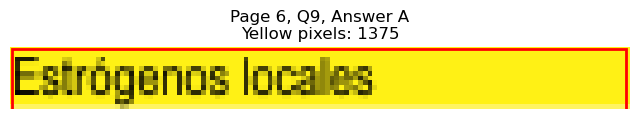

Page 6, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=151.1, y1=695.3
Page 6, Q9, B: Yellow pixels: 132
Page 6, Q9, B: Total non-white pixels: 595
Page 6, Q9, B: Yellow percentage: 22.2%


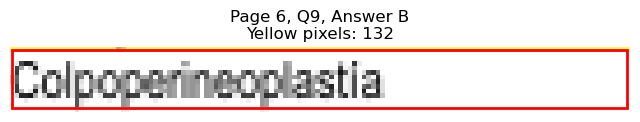

Page 6, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=431.8, y1=682.7
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 503
Page 6, Q9, C: Yellow percentage: 0.0%


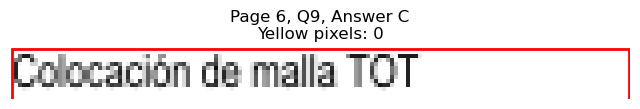

Page 6, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=395.2, y1=695.3
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 340
Page 6, Q9, D: Yellow percentage: 0.0%


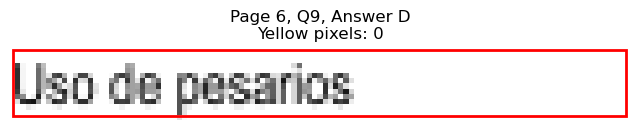


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=165.1, y1=745.8
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 510
Page 6, Q10, A: Yellow percentage: 0.0%


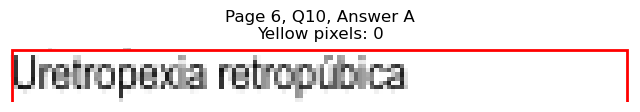

Page 6, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=205.7, y1=758.4
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 689
Page 6, Q10, B: Yellow percentage: 0.0%


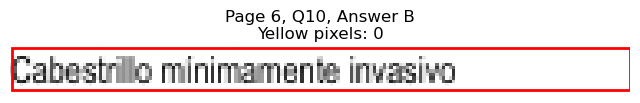

Page 6, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=376.7, y1=745.8
Page 6, Q10, C: Yellow pixels: 1089
Page 6, Q10, C: Total non-white pixels: 1300
Page 6, Q10, C: Yellow percentage: 83.8%


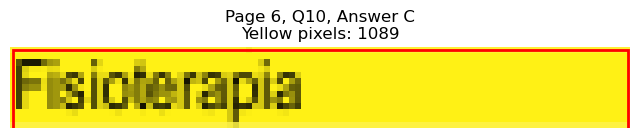

Page 6, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=395.2, y1=695.3
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 340
Page 6, Q10, D: Yellow percentage: 0.0%


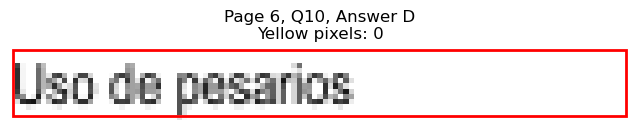


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=120.0, y1=114.7
Page 7, Q1, A: Yellow pixels: 1133
Page 7, Q1, A: Total non-white pixels: 1339
Page 7, Q1, A: Yellow percentage: 84.6%


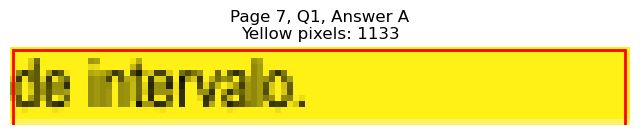

Page 7, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=112.5, y1=127.3
Page 7, Q1, B: Yellow pixels: 95
Page 7, Q1, B: Total non-white pixels: 327
Page 7, Q1, B: Yellow percentage: 29.1%


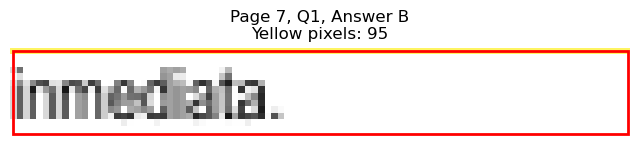

Page 7, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=370.6, y1=114.7
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 204
Page 7, Q1, C: Yellow percentage: 0.0%


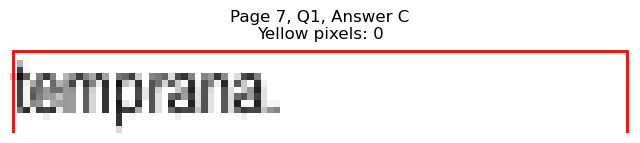

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=364.6, y1=127.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 182
Page 7, Q1, D: Yellow percentage: 0.0%


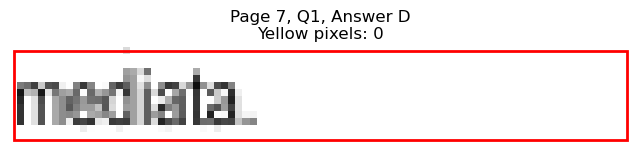


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=127.0, y1=203.0
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 270
Page 7, Q2, A: Yellow percentage: 0.0%


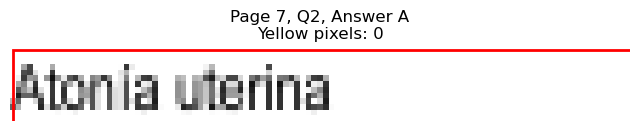

Page 7, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=148.1, y1=215.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 367
Page 7, Q2, B: Yellow percentage: 0.0%


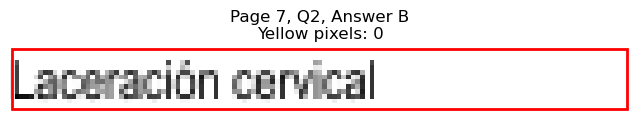

Page 7, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=400.7, y1=203.0
Page 7, Q2, C: Yellow pixels: 1337
Page 7, Q2, C: Total non-white pixels: 1612
Page 7, Q2, C: Yellow percentage: 82.9%


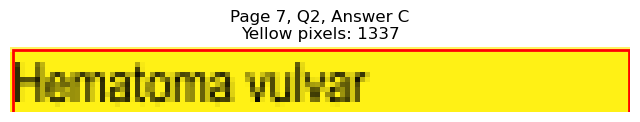

Page 7, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=403.3, y1=215.6
Page 7, Q2, D: Yellow pixels: 127
Page 7, Q2, D: Total non-white pixels: 534
Page 7, Q2, D: Yellow percentage: 23.8%


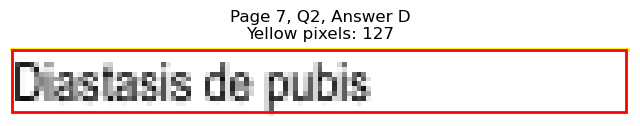


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=111.4, y1=278.7
Page 7, Q3, A: Yellow pixels: 1036
Page 7, Q3, A: Total non-white pixels: 1222
Page 7, Q3, A: Yellow percentage: 84.8%


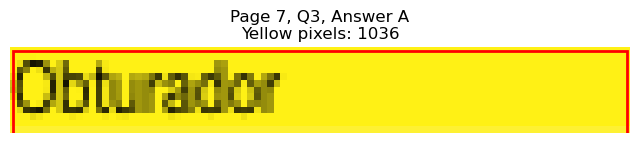

Page 7, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=103.9, y1=291.5
Page 7, Q3, B: Yellow pixels: 86
Page 7, Q3, B: Total non-white pixels: 241
Page 7, Q3, B: Yellow percentage: 35.7%


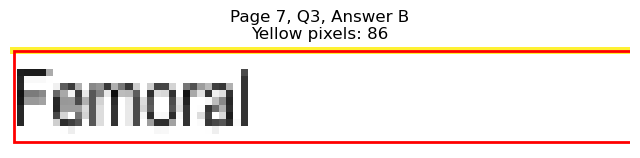

Page 7, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=376.7, y1=278.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 240
Page 7, Q3, C: Yellow percentage: 0.0%


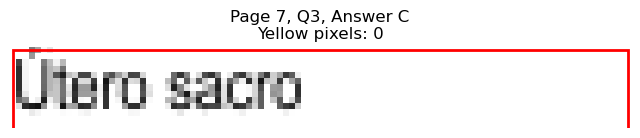

Page 7, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=366.2, y1=291.5
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 182
Page 7, Q3, D: Yellow percentage: 0.0%


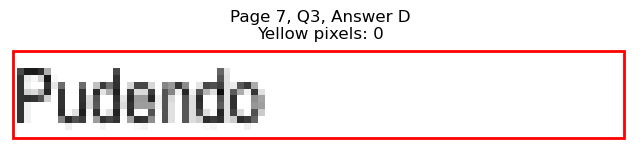


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=101.9, y1=354.6
Page 7, Q4, A: Yellow pixels: 84
Page 7, Q4, A: Total non-white pixels: 250
Page 7, Q4, A: Yellow percentage: 33.6%


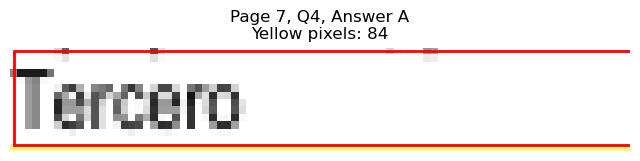

Page 7, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=106.9, y1=367.2
Page 7, Q4, B: Yellow pixels: 1007
Page 7, Q4, B: Total non-white pixels: 1246
Page 7, Q4, B: Yellow percentage: 80.8%


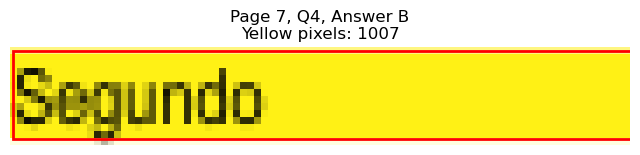

Page 7, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=361.6, y1=354.6
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 153
Page 7, Q4, C: Yellow percentage: 0.0%


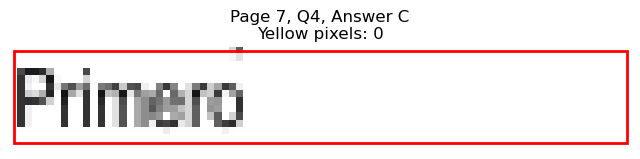

Page 7, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=357.2, y1=367.2
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 148
Page 7, Q4, D: Yellow percentage: 0.0%


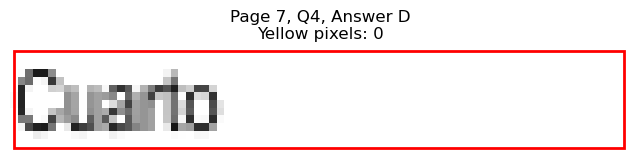


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=181.6, y1=417.6
Page 7, Q5, A: Yellow pixels: 1701
Page 7, Q5, A: Total non-white pixels: 2296
Page 7, Q5, A: Yellow percentage: 74.1%


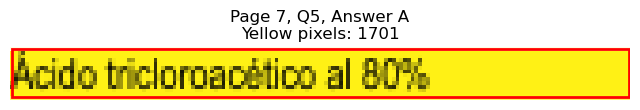

Page 7, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=182.7, y1=430.3
Page 7, Q5, B: Yellow pixels: 165
Page 7, Q5, B: Total non-white pixels: 722
Page 7, Q5, B: Yellow percentage: 22.9%


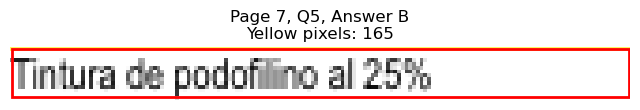

Page 7, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=395.2, y1=417.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 342
Page 7, Q5, C: Yellow percentage: 0.0%


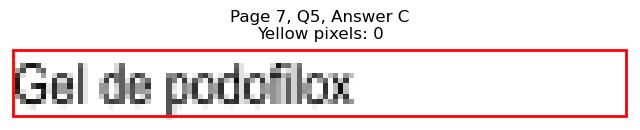

Page 7, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=371.7, y1=430.3
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 220
Page 7, Q5, D: Yellow percentage: 0.0%


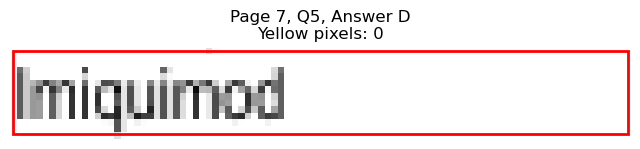


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=129.0, y1=493.4
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 314
Page 7, Q6, A: Yellow percentage: 0.0%


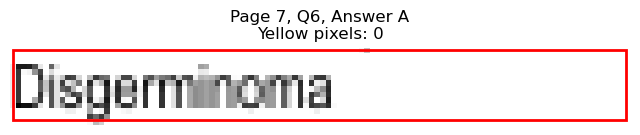

Page 7, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=144.0, y1=506.0
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 331
Page 7, Q6, B: Yellow percentage: 0.0%


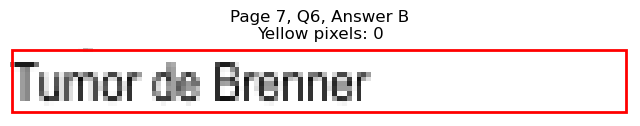

Page 7, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=433.4, y1=493.4
Page 7, Q6, C: Yellow pixels: 157
Page 7, Q6, C: Total non-white pixels: 690
Page 7, Q6, C: Yellow percentage: 22.8%


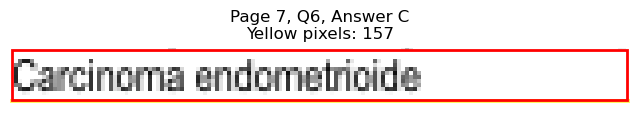

Page 7, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=417.8, y1=506.0
Page 7, Q6, D: Yellow pixels: 1477
Page 7, Q6, D: Total non-white pixels: 1836
Page 7, Q6, D: Yellow percentage: 80.4%


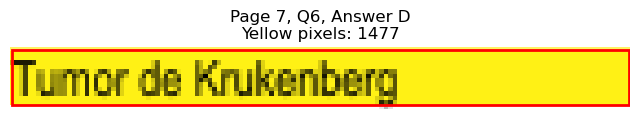


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=258.9, y1=543.8
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 967
Page 7, Q7, A: Yellow percentage: 0.0%


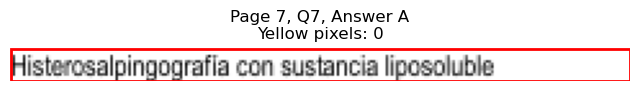

Page 7, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=204.2, y1=556.4
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 698
Page 7, Q7, B: Yellow percentage: 0.0%


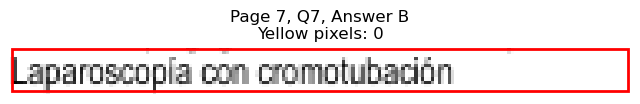

Page 7, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=433.4, y1=543.8
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 720
Page 7, Q7, C: Yellow percentage: 0.0%


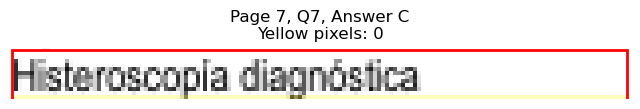

Page 7, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=524.1, y1=556.4
Page 7, Q7, D: Yellow pixels: 1995
Page 7, Q7, D: Total non-white pixels: 2996
Page 7, Q7, D: Yellow percentage: 66.6%


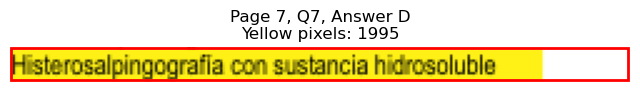


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=98.9, y1=594.4
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 135
Page 7, Q8, A: Yellow percentage: 0.0%


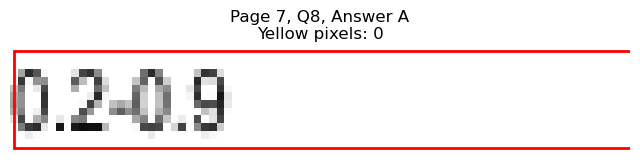

Page 7, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=98.9, y1=607.0
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 131
Page 7, Q8, B: Yellow percentage: 0.0%


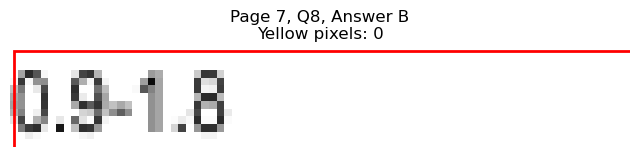

Page 7, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=350.6, y1=594.4
Page 7, Q8, C: Yellow pixels: 74
Page 7, Q8, C: Total non-white pixels: 155
Page 7, Q8, C: Yellow percentage: 47.7%


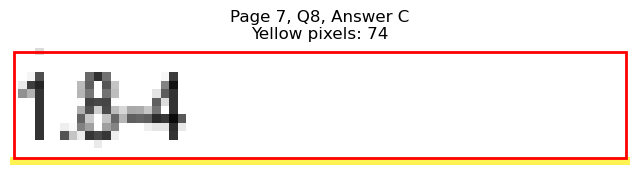

Page 7, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=343.1, y1=607.0
Page 7, Q8, D: Yellow pixels: 821
Page 7, Q8, D: Total non-white pixels: 871
Page 7, Q8, D: Yellow percentage: 94.3%


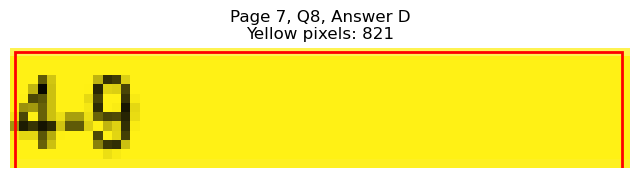


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=172.6, y1=657.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 525
Page 7, Q9, A: Yellow percentage: 0.0%


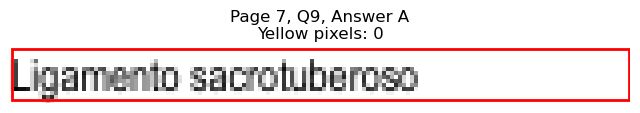

Page 7, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=119.9, y1=670.1
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 258
Page 7, Q9, B: Yellow percentage: 0.0%


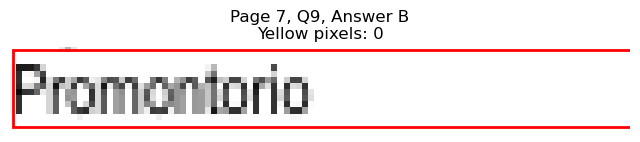

Page 7, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=352.6, y1=657.5
Page 7, Q9, C: Yellow pixels: 76
Page 7, Q9, C: Total non-white pixels: 191
Page 7, Q9, C: Yellow percentage: 39.8%


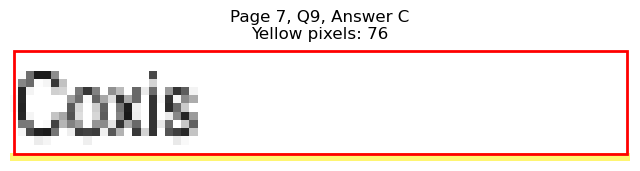

Page 7, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=385.7, y1=670.1
Page 7, Q9, D: Yellow pixels: 1186
Page 7, Q9, D: Total non-white pixels: 1526
Page 7, Q9, D: Yellow percentage: 77.7%


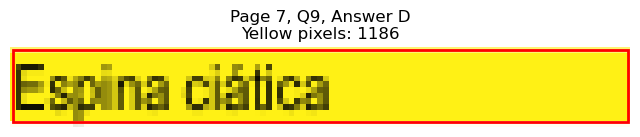


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=65.2, y1=745.8
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 63
Page 7, Q10, A: Yellow percentage: 0.0%


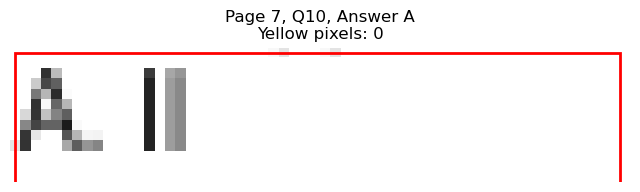

Page 7, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=78.4, y1=758.4
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 32
Page 7, Q10, B: Yellow percentage: 0.0%


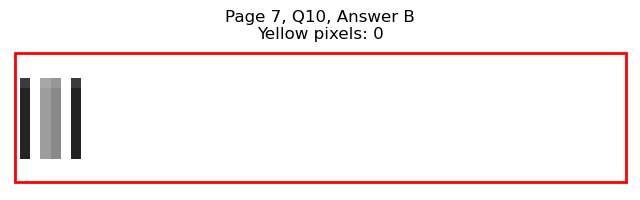

Page 7, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=324.4, y1=745.8
Page 7, Q10, C: Yellow pixels: 738
Page 7, Q10, C: Total non-white pixels: 780
Page 7, Q10, C: Yellow percentage: 94.6%


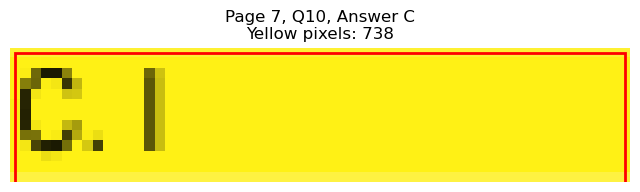

Page 7, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=324.4, y1=758.4
Page 7, Q10, D: Yellow pixels: 60
Page 7, Q10, D: Total non-white pixels: 142
Page 7, Q10, D: Yellow percentage: 42.3%


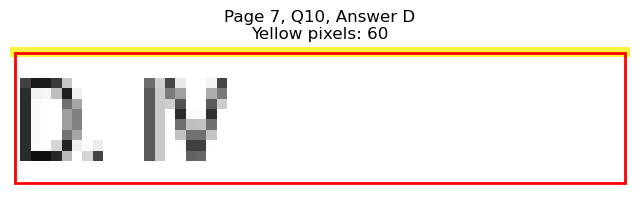


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=121.5, y1=114.7
Page 8, Q1, A: Yellow pixels: 1133
Page 8, Q1, A: Total non-white pixels: 1352
Page 8, Q1, A: Yellow percentage: 83.8%


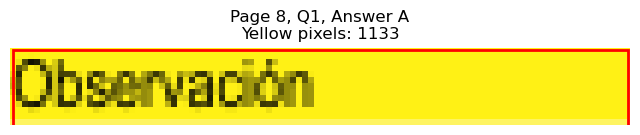

Page 8, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=177.6, y1=127.3
Page 8, Q1, B: Yellow pixels: 160
Page 8, Q1, B: Total non-white pixels: 720
Page 8, Q1, B: Yellow percentage: 22.2%


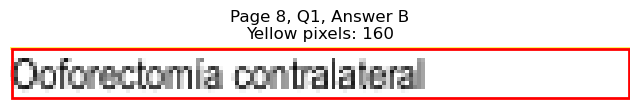

Page 8, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=414.8, y1=114.7
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 467
Page 8, Q1, C: Yellow percentage: 0.0%


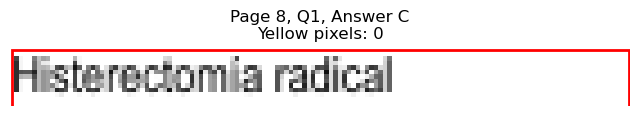

Page 8, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=386.2, y1=127.3
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 308
Page 8, Q1, D: Yellow percentage: 0.0%


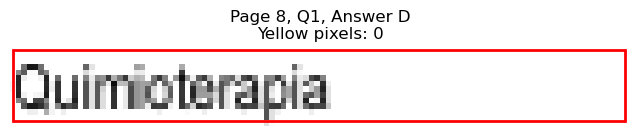


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=154.1, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 433
Page 8, Q2, A: Yellow percentage: 0.0%


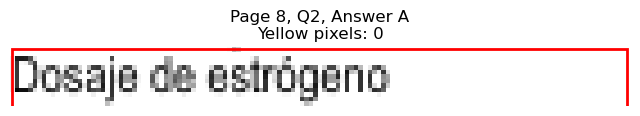

Page 8, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=163.6, y1=190.4
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 497
Page 8, Q2, B: Yellow percentage: 0.0%


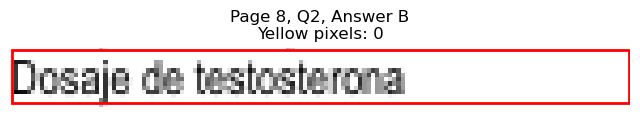

Page 8, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=378.7, y1=177.8
Page 8, Q2, C: Yellow pixels: 1131
Page 8, Q2, C: Total non-white pixels: 1326
Page 8, Q2, C: Yellow percentage: 85.3%


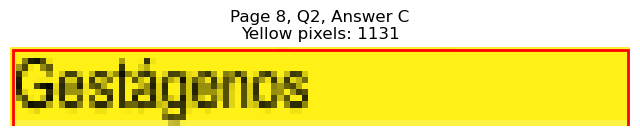

Page 8, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=383.2, y1=190.4
Page 8, Q2, D: Yellow pixels: 105
Page 8, Q2, D: Total non-white pixels: 374
Page 8, Q2, D: Yellow percentage: 28.1%


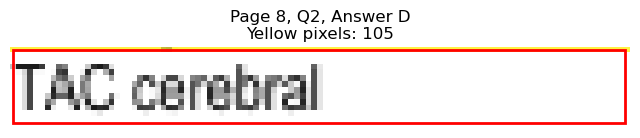


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=96.4, y1=240.9
Page 8, Q3, A: Yellow pixels: 923
Page 8, Q3, A: Total non-white pixels: 1027
Page 8, Q3, A: Yellow percentage: 89.9%


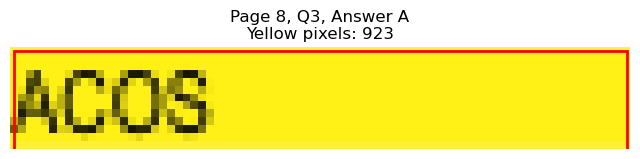

Page 8, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=104.9, y1=253.5
Page 8, Q3, B: Yellow pixels: 87
Page 8, Q3, B: Total non-white pixels: 260
Page 8, Q3, B: Yellow percentage: 33.5%


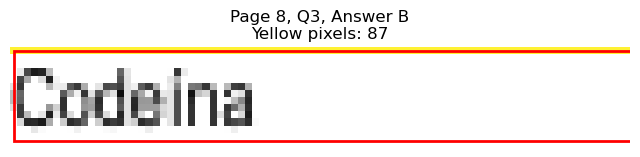

Page 8, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=419.3, y1=240.9
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 471
Page 8, Q3, C: Yellow percentage: 0.0%


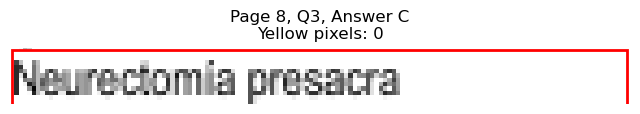

Page 8, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=376.3, y1=253.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 248
Page 8, Q3, D: Yellow percentage: 0.0%


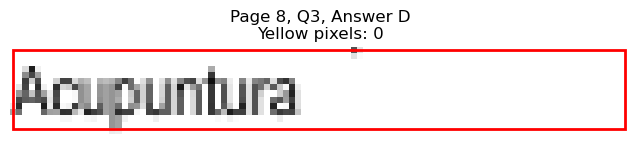


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=157.1, y1=316.7
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 621
Page 8, Q4, A: Yellow percentage: 0.0%


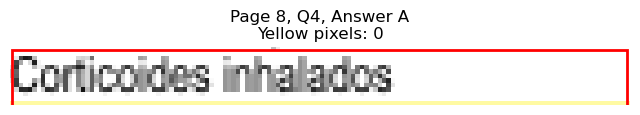

Page 8, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=194.2, y1=329.3
Page 8, Q4, B: Yellow pixels: 1658
Page 8, Q4, B: Total non-white pixels: 2478
Page 8, Q4, B: Yellow percentage: 66.9%


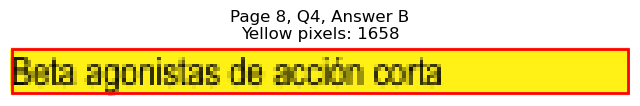

Page 8, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=364.1, y1=316.7
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 189
Page 8, Q4, C: Yellow percentage: 0.0%


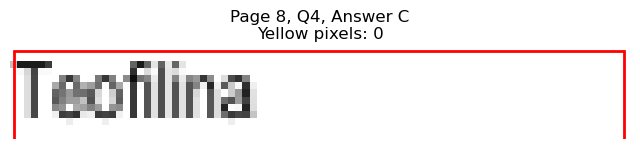

Page 8, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=380.7, y1=329.3
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 263
Page 8, Q4, D: Yellow percentage: 0.0%


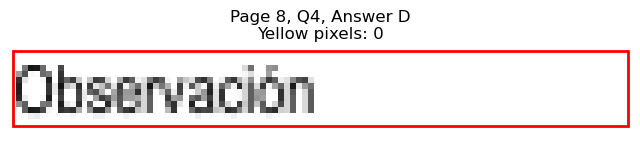


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=124.0, y1=392.4
Page 8, Q5, A: Yellow pixels: 106
Page 8, Q5, A: Total non-white pixels: 393
Page 8, Q5, A: Yellow percentage: 27.0%


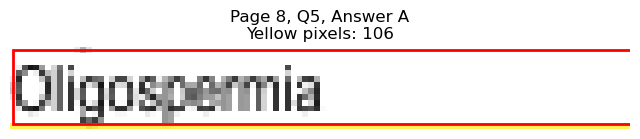

Page 8, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=144.5, y1=405.0
Page 8, Q5, B: Yellow pixels: 1362
Page 8, Q5, B: Total non-white pixels: 1651
Page 8, Q5, B: Yellow percentage: 82.5%


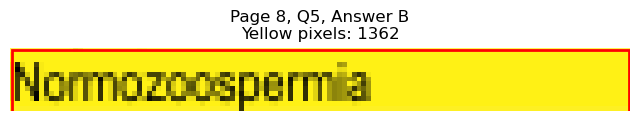

Page 8, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=390.2, y1=392.4
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 326
Page 8, Q5, C: Yellow percentage: 0.0%


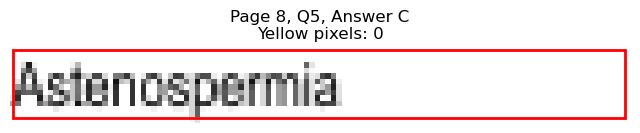

Page 8, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=447.9, y1=405.0
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 623
Page 8, Q5, D: Yellow percentage: 0.0%


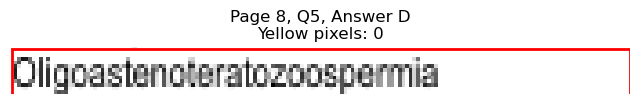


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=184.7, y1=480.7
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 599
Page 8, Q6, A: Yellow percentage: 0.0%


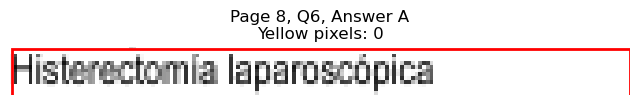

Page 8, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=190.2, y1=493.4
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 632
Page 8, Q6, B: Yellow percentage: 0.0%


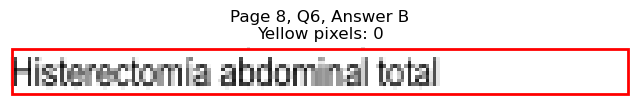

Page 8, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=461.3, y1=480.7
Page 8, Q6, C: Yellow pixels: 1888
Page 8, Q6, C: Total non-white pixels: 2405
Page 8, Q6, C: Yellow percentage: 78.5%


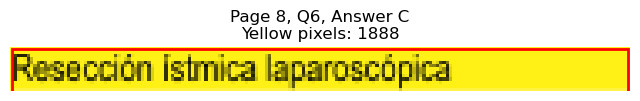

Page 8, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=415.4, y1=493.4
Page 8, Q6, D: Yellow pixels: 139
Page 8, Q6, D: Total non-white pixels: 593
Page 8, Q6, D: Yellow percentage: 23.4%


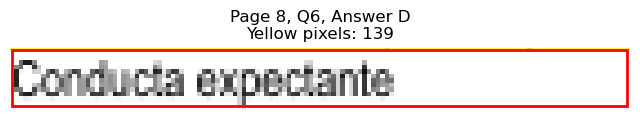


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=212.2, y1=556.4
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 716
Page 8, Q7, A: Yellow percentage: 0.0%


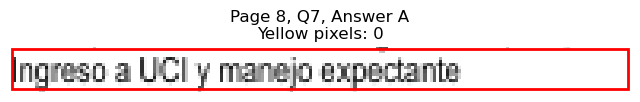

Page 8, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=214.8, y1=569.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 734
Page 8, Q7, B: Yellow percentage: 0.0%


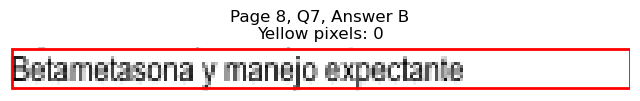

Page 8, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=509.7, y1=556.4
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 866
Page 8, Q7, C: Yellow percentage: 0.0%


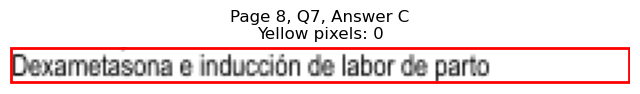

Page 8, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=482.0, y1=569.2
Page 8, Q7, D: Yellow pixels: 2128
Page 8, Q7, D: Total non-white pixels: 2884
Page 8, Q7, D: Yellow percentage: 73.8%


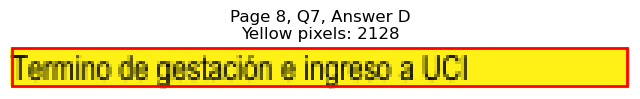


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=286.5, y1=644.9
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 1125
Page 8, Q8, A: Yellow percentage: 0.0%


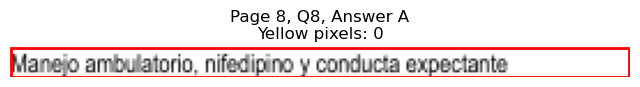

Page 8, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=292.5, y1=657.5
Page 8, Q8, B: Yellow pixels: 275
Page 8, Q8, B: Total non-white pixels: 1439
Page 8, Q8, B: Yellow percentage: 19.1%


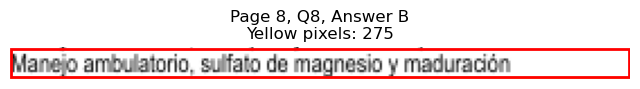

Page 8, Q8 - C: Detected box: x0=68.8, y0=657.5, x1=277.5, y1=670.1
Page 8, Q8, C: Yellow pixels: 2545
Page 8, Q8, C: Total non-white pixels: 3640
Page 8, Q8, C: Yellow percentage: 69.9%


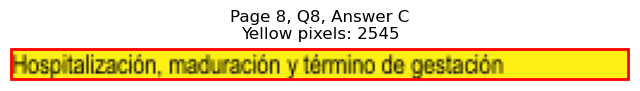

Page 8, Q8 - D: Detected box: x0=68.8, y0=670.1, x1=291.0, y1=682.7
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 1422
Page 8, Q8, D: Yellow percentage: 0.0%


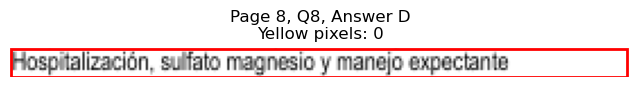


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=733.2, x1=233.3, y1=745.8
Page 8, Q9, A: Yellow pixels: 1
Page 8, Q9, A: Total non-white pixels: 1074
Page 8, Q9, A: Yellow percentage: 0.1%


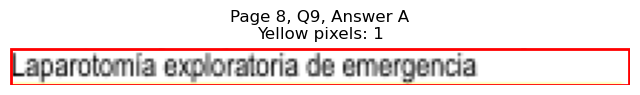

Page 8, Q9 - B: Detected box: x0=68.3, y0=745.8, x1=269.9, y1=758.4
Page 8, Q9, B: Yellow pixels: 2024
Page 8, Q9, B: Total non-white pixels: 3019
Page 8, Q9, B: Yellow percentage: 67.0%


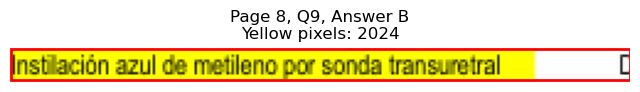

Page 8, Q9 - C: Detected box: x0=327.5, y0=733.2, x1=503.0, y1=745.8
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 888
Page 8, Q9, C: Yellow percentage: 0.0%


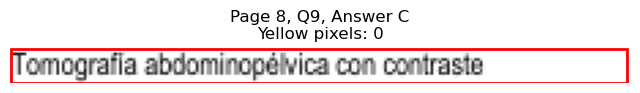

Page 8, Q9 - D: Detected box: x0=327.5, y0=745.8, x1=538.2, y1=758.4
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 1035
Page 8, Q9, D: Yellow percentage: 0.0%


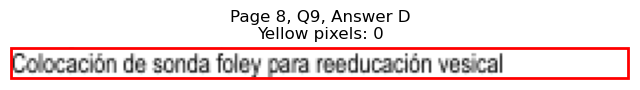


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=183.1, y1=127.3
Page 9, Q1, A: Yellow pixels: 166
Page 9, Q1, A: Total non-white pixels: 790
Page 9, Q1, A: Yellow percentage: 21.0%


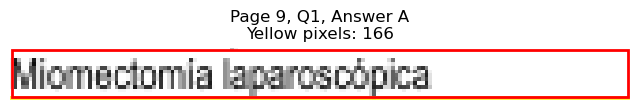

Page 9, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=156.1, y1=139.9
Page 9, Q1, B: Yellow pixels: 1457
Page 9, Q1, B: Total non-white pixels: 1807
Page 9, Q1, B: Yellow percentage: 80.6%


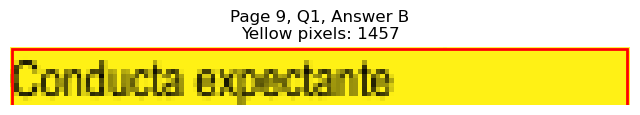

Page 9, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=417.3, y1=127.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 436
Page 9, Q1, C: Yellow percentage: 0.0%


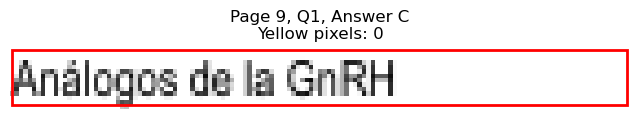

Page 9, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=414.3, y1=139.9
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 443
Page 9, Q1, D: Yellow percentage: 0.0%


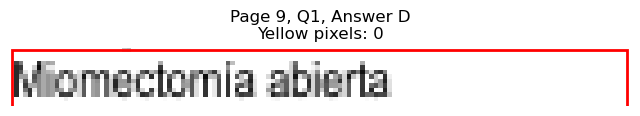


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=140.1, y1=190.4
Page 9, Q2, A: Yellow pixels: 123
Page 9, Q2, A: Total non-white pixels: 501
Page 9, Q2, A: Yellow percentage: 24.6%


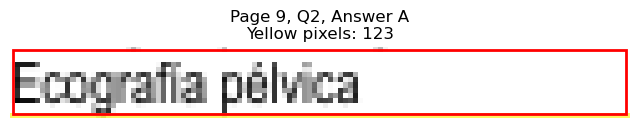

Page 9, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=121.5, y1=203.0
Page 9, Q2, B: Yellow pixels: 1133
Page 9, Q2, B: Total non-white pixels: 1352
Page 9, Q2, B: Yellow percentage: 83.8%


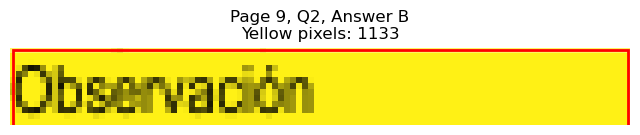

Page 9, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=413.3, y1=190.4
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 428
Page 9, Q2, C: Yellow percentage: 0.0%


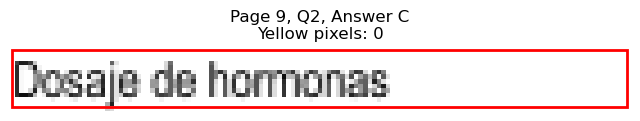

Page 9, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=396.2, y1=203.0
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 351
Page 9, Q2, D: Yellow percentage: 0.0%


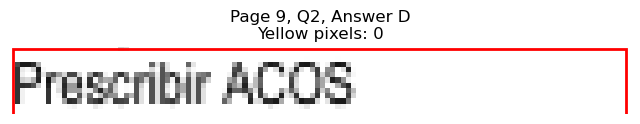


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=208.7, y1=253.5
Page 9, Q3, A: Yellow pixels: 1921
Page 9, Q3, A: Total non-white pixels: 2674
Page 9, Q3, A: Yellow percentage: 71.8%


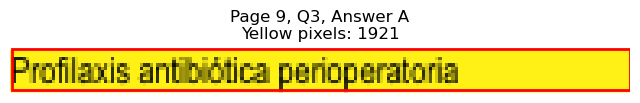

Page 9, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=262.5, y1=266.1
Page 9, Q3, B: Yellow pixels: 213
Page 9, Q3, B: Total non-white pixels: 1187
Page 9, Q3, B: Yellow percentage: 17.9%


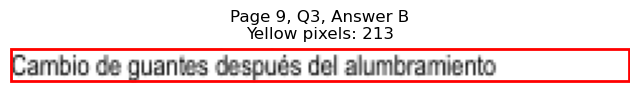

Page 9, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=489.6, y1=253.5
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 827
Page 9, Q3, C: Yellow percentage: 0.0%


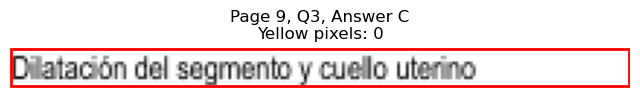

Page 9, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=437.8, y1=266.1
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 562
Page 9, Q3, D: Yellow percentage: 0.0%


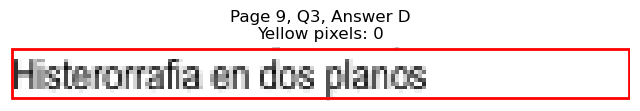


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=331.7, y1=316.7
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 1611
Page 9, Q4, A: Yellow percentage: 0.0%


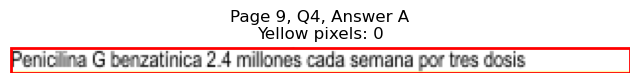

Page 9, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=278.6, y1=329.3
Page 9, Q4, B: Yellow pixels: 2327
Page 9, Q4, B: Total non-white pixels: 3654
Page 9, Q4, B: Yellow percentage: 63.7%


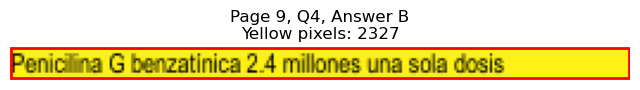

Page 9, Q4 - C: Detected box: x0=68.8, y0=329.2, x1=317.2, y1=341.9
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 1495
Page 9, Q4, C: Yellow percentage: 0.0%


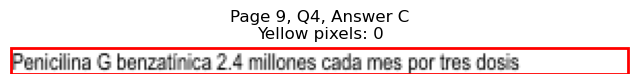

Page 9, Q4 - D: Detected box: x0=68.8, y0=341.9, x1=254.3, y1=354.6
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 844
Page 9, Q4, D: Yellow percentage: 0.0%


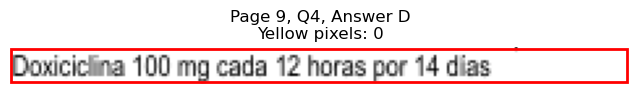


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=157.1, y1=417.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 440
Page 9, Q5, A: Yellow percentage: 0.0%


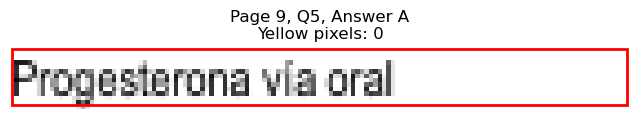

Page 9, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=133.0, y1=430.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 314
Page 9, Q5, B: Yellow percentage: 0.0%


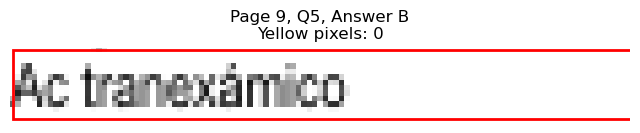

Page 9, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=393.3, y1=417.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 313
Page 9, Q5, C: Yellow percentage: 0.0%


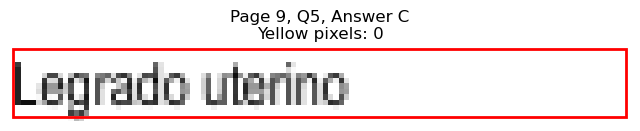

Page 9, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=471.5, y1=430.3
Page 9, Q5, D: Yellow pixels: 1778
Page 9, Q5, D: Total non-white pixels: 2730
Page 9, Q5, D: Yellow percentage: 65.1%


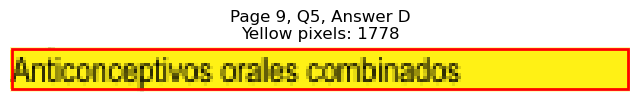


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=136.5, y1=493.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 347
Page 9, Q6, A: Yellow percentage: 0.0%


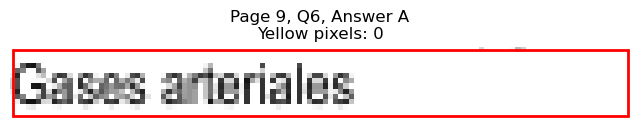

Page 9, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=152.5, y1=506.0
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 450
Page 9, Q6, B: Yellow percentage: 0.0%


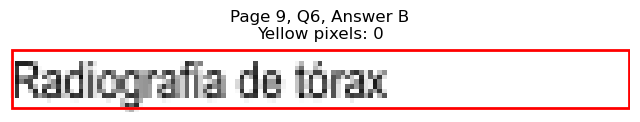

Page 9, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=437.8, y1=493.4
Page 9, Q6, C: Yellow pixels: 1516
Page 9, Q6, C: Total non-white pixels: 2254
Page 9, Q6, C: Yellow percentage: 67.3%


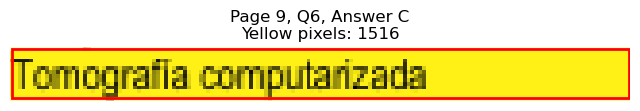

Page 9, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=408.3, y1=506.0
Page 9, Q6, D: Yellow pixels: 1
Page 9, Q6, D: Total non-white pixels: 555
Page 9, Q6, D: Yellow percentage: 0.2%


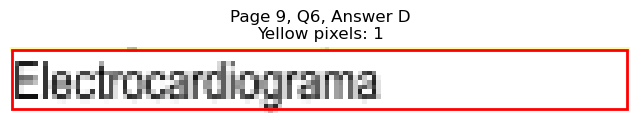


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=182.2, y1=581.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 741
Page 9, Q7, A: Yellow percentage: 0.0%


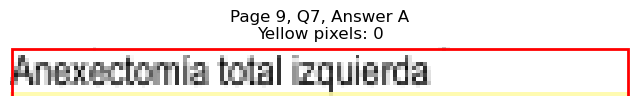

Page 9, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=223.7, y1=594.4
Page 9, Q7, B: Yellow pixels: 1862
Page 9, Q7, B: Total non-white pixels: 2884
Page 9, Q7, B: Yellow percentage: 64.6%


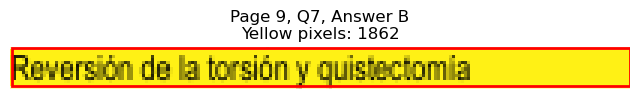

Page 9, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=523.7, y1=581.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 989
Page 9, Q7, C: Yellow percentage: 0.0%


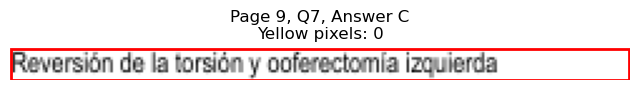

Page 9, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=415.4, y1=594.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 456
Page 9, Q7, D: Yellow percentage: 0.0%


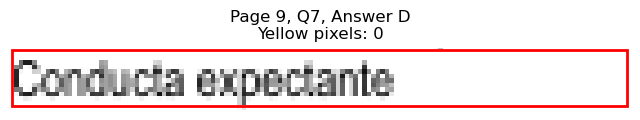


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=219.8, y1=644.9
Page 9, Q8, A: Yellow pixels: 2043
Page 9, Q8, A: Total non-white pixels: 2626
Page 9, Q8, A: Yellow percentage: 77.8%


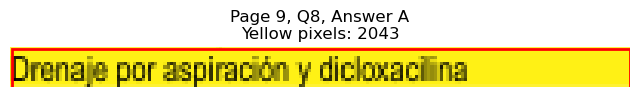

Page 9, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=202.7, y1=657.5
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 677
Page 9, Q8, B: Yellow percentage: 0.0%


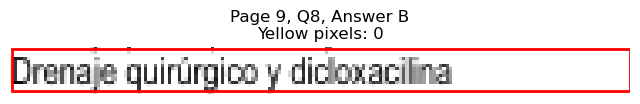

Page 9, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=399.3, y1=644.9
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 387
Page 9, Q8, C: Yellow percentage: 0.0%


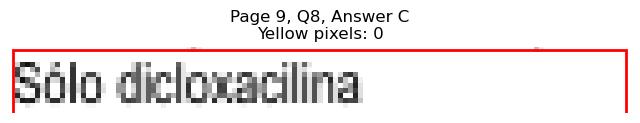

Page 9, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=430.4, y1=657.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 513
Page 9, Q8, D: Yellow percentage: 0.0%


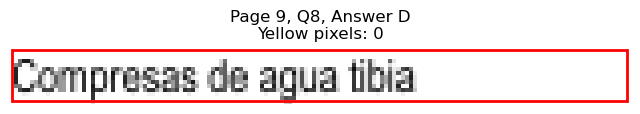


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=212.2, y1=720.6
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 734
Page 9, Q9, A: Yellow percentage: 0.0%


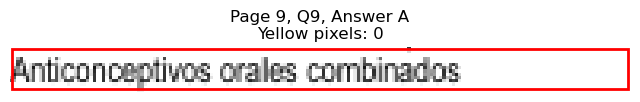

Page 9, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=138.0, y1=733.2
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 384
Page 9, Q9, B: Yellow percentage: 0.0%


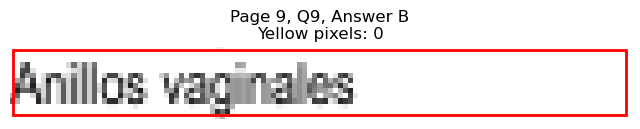

Page 9, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=373.1, y1=720.6
Page 9, Q9, C: Yellow pixels: 1118
Page 9, Q9, C: Total non-white pixels: 1358
Page 9, Q9, C: Yellow percentage: 82.3%


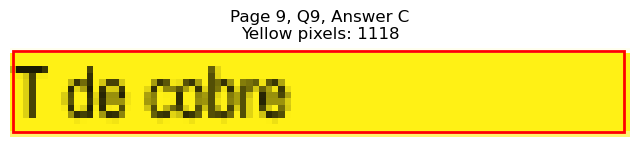

Page 9, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=425.3, y1=733.2
Page 9, Q9, D: Yellow pixels: 149
Page 9, Q9, D: Total non-white pixels: 659
Page 9, Q9, D: Yellow percentage: 22.6%


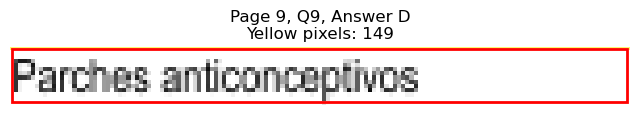


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=261.4, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 959
Page 10, Q1, A: Yellow percentage: 0.0%


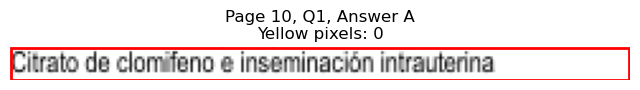

Page 10, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=242.9, y1=127.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 884
Page 10, Q1, B: Yellow percentage: 0.0%


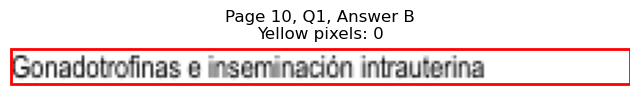

Page 10, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=380.7, y1=114.7
Page 10, Q1, C: Yellow pixels: 1150
Page 10, Q1, C: Total non-white pixels: 1352
Page 10, Q1, C: Yellow percentage: 85.1%


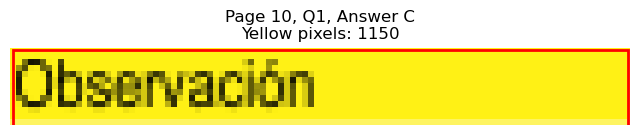

Page 10, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=407.2, y1=127.3
Page 10, Q1, D: Yellow pixels: 131
Page 10, Q1, D: Total non-white pixels: 530
Page 10, Q1, D: Yellow percentage: 24.7%


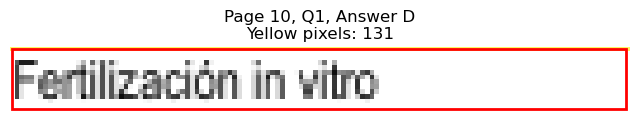


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=154.6, y1=177.8
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 587
Page 10, Q2, A: Yellow percentage: 0.0%


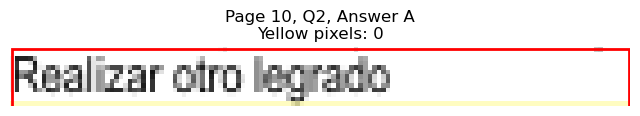

Page 10, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=127.0, y1=190.4
Page 10, Q2, B: Yellow pixels: 1079
Page 10, Q2, B: Total non-white pixels: 1526
Page 10, Q2, B: Yellow percentage: 70.7%


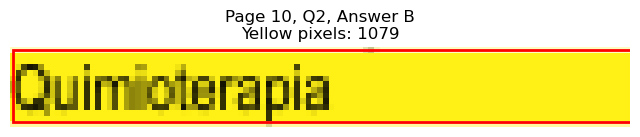

Page 10, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=399.3, y1=177.8
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 373
Page 10, Q2, C: Yellow percentage: 0.0%


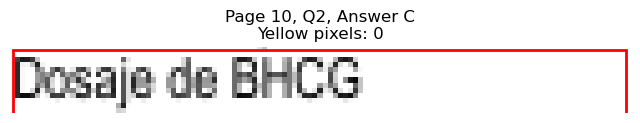

Page 10, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=429.9, y1=190.4
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 541
Page 10, Q2, D: Yellow percentage: 0.0%


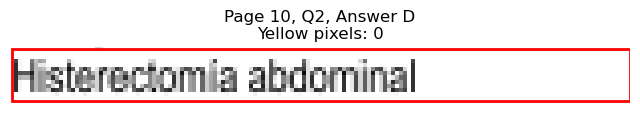


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=177.6, y1=228.3
Page 10, Q3, A: Yellow pixels: 1538
Page 10, Q3, A: Total non-white pixels: 2240
Page 10, Q3, A: Yellow percentage: 68.7%


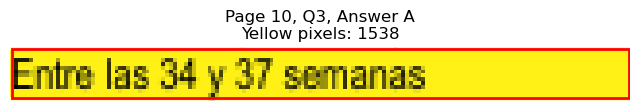

Page 10, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=177.6, y1=240.9
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 680
Page 10, Q3, B: Yellow percentage: 0.0%


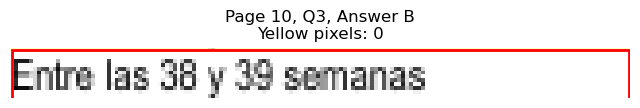

Page 10, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=437.3, y1=228.3
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 527
Page 10, Q3, C: Yellow percentage: 0.0%


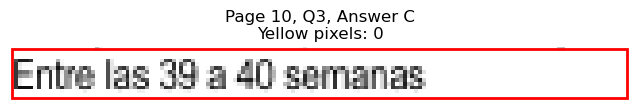

Page 10, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=450.4, y1=240.9
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 606
Page 10, Q3, D: Yellow percentage: 0.0%


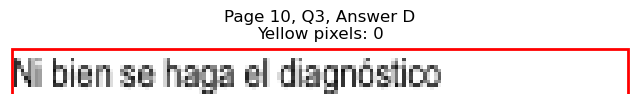


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=183.6, y1=304.1
Page 10, Q4, A: Yellow pixels: 1730
Page 10, Q4, A: Total non-white pixels: 2324
Page 10, Q4, A: Yellow percentage: 74.4%


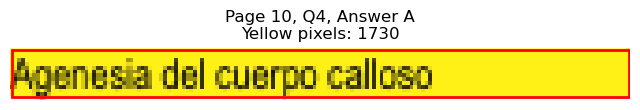

Page 10, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=143.1, y1=316.7
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 508
Page 10, Q4, B: Yellow percentage: 0.0%


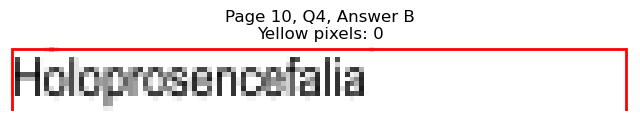

Page 10, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=393.3, y1=304.1
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 363
Page 10, Q4, C: Yellow percentage: 0.0%


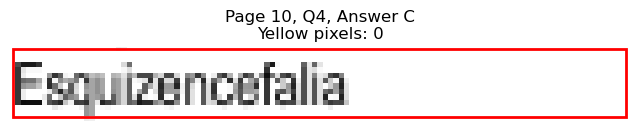

Page 10, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=378.2, y1=316.7
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 275
Page 10, Q4, D: Yellow percentage: 0.0%


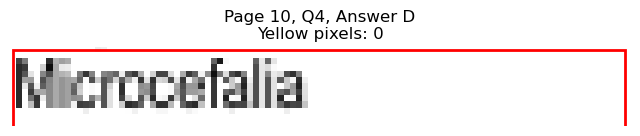


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=148.1, y1=379.8
Page 10, Q5, A: Yellow pixels: 1343
Page 10, Q5, A: Total non-white pixels: 1703
Page 10, Q5, A: Yellow percentage: 78.9%


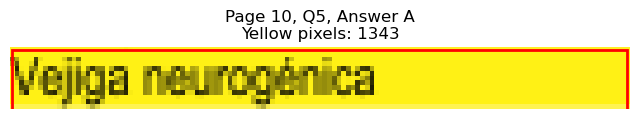

Page 10, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=142.0, y1=392.4
Page 10, Q5, B: Yellow pixels: 121
Page 10, Q5, B: Total non-white pixels: 531
Page 10, Q5, B: Yellow percentage: 22.8%


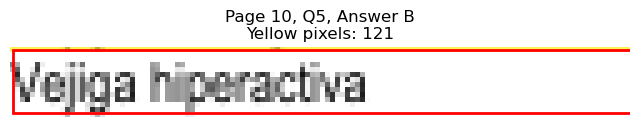

Page 10, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=465.4, y1=379.8
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 699
Page 10, Q5, C: Yellow percentage: 0.0%


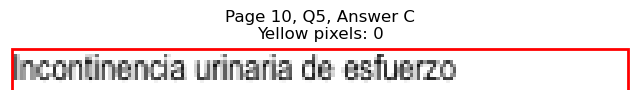

Page 10, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=455.0, y1=392.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 650
Page 10, Q5, D: Yellow percentage: 0.0%


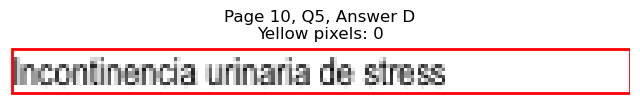


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=165.0, y1=430.3
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 492
Page 10, Q6, A: Yellow percentage: 0.0%


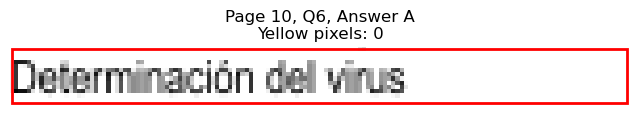

Page 10, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=125.4, y1=442.9
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 267
Page 10, Q6, B: Yellow percentage: 0.0%


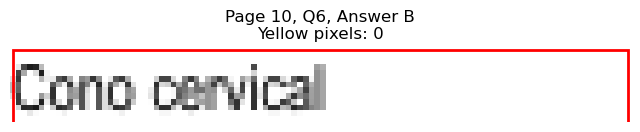

Page 10, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=380.2, y1=430.3
Page 10, Q6, C: Yellow pixels: 104
Page 10, Q6, C: Total non-white pixels: 365
Page 10, Q6, C: Yellow percentage: 28.5%


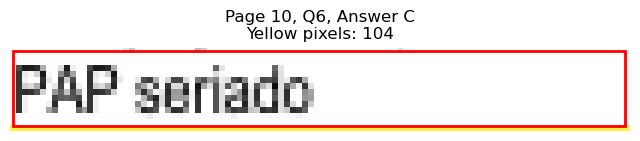

Page 10, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=380.2, y1=442.9
Page 10, Q6, D: Yellow pixels: 1138
Page 10, Q6, D: Total non-white pixels: 1352
Page 10, Q6, D: Yellow percentage: 84.2%


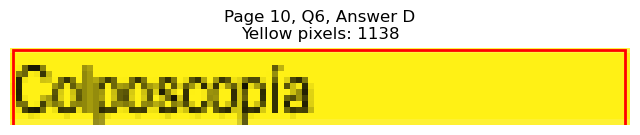


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=134.5, y1=518.6
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 302
Page 10, Q7, A: Yellow percentage: 0.0%


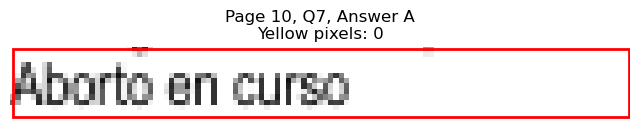

Page 10, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=185.2, y1=531.2
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 585
Page 10, Q7, B: Yellow percentage: 0.0%


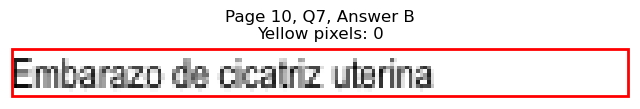

Page 10, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=440.3, y1=518.6
Page 10, Q7, C: Yellow pixels: 164
Page 10, Q7, C: Total non-white pixels: 750
Page 10, Q7, C: Yellow percentage: 21.9%


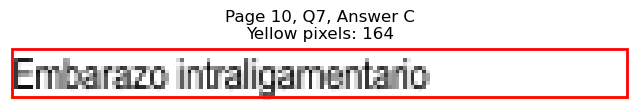

Page 10, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=440.3, y1=531.2
Page 10, Q7, D: Yellow pixels: 1723
Page 10, Q7, D: Total non-white pixels: 2296
Page 10, Q7, D: Yellow percentage: 75.0%


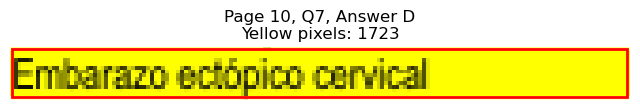


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=269.0, y1=569.2
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 989
Page 10, Q8, A: Yellow percentage: 0.0%


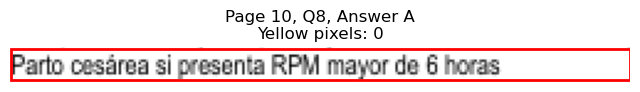

Page 10, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=332.1, y1=581.8
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 1281
Page 10, Q8, B: Yellow percentage: 0.0%


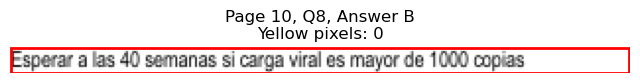

Page 10, Q8 - C: Detected box: x0=68.8, y0=581.7, x1=347.2, y1=594.4
Page 10, Q8, C: Yellow pixels: 330
Page 10, Q8, C: Total non-white pixels: 1711
Page 10, Q8, C: Yellow percentage: 19.3%


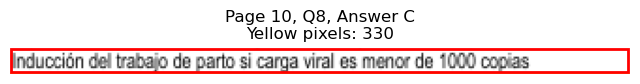

Page 10, Q8 - D: Detected box: x0=68.8, y0=594.3, x1=285.9, y1=607.0
Page 10, Q8, D: Yellow pixels: 2685
Page 10, Q8, D: Total non-white pixels: 3484
Page 10, Q8, D: Yellow percentage: 77.1%


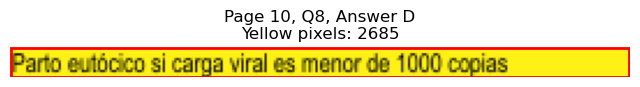


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=199.2, y1=670.1
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 565
Page 10, Q9, A: Yellow percentage: 0.0%


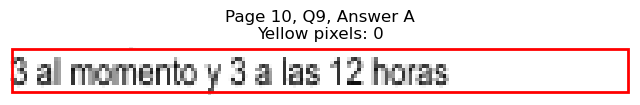

Page 10, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=199.2, y1=682.7
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 558
Page 10, Q9, B: Yellow percentage: 0.0%


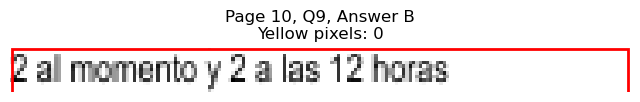

Page 10, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=458.5, y1=670.1
Page 10, Q9, C: Yellow pixels: 1929
Page 10, Q9, C: Total non-white pixels: 2548
Page 10, Q9, C: Yellow percentage: 75.7%


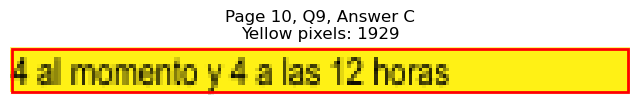

Page 10, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=419.8, y1=682.7
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 546
Page 10, Q9, D: Yellow percentage: 0.0%


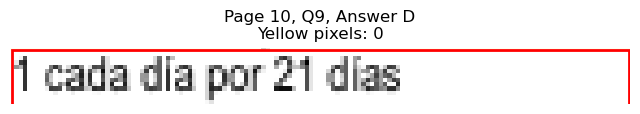


Page 10, Q9 - Selected Answer: C (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=180.6, y1=745.8
Page 10, Q10, A: Yellow pixels: 2
Page 10, Q10, A: Total non-white pixels: 726
Page 10, Q10, A: Yellow percentage: 0.3%


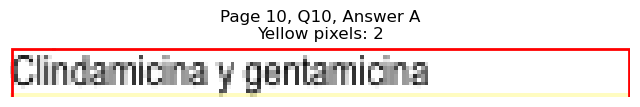

Page 10, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=174.6, y1=758.4
Page 10, Q10, B: Yellow pixels: 1643
Page 10, Q10, B: Total non-white pixels: 2198
Page 10, Q10, B: Yellow percentage: 74.7%


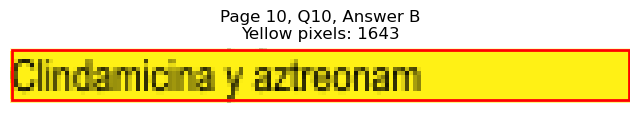

Page 10, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=429.3, y1=745.8
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 528
Page 10, Q10, C: Yellow percentage: 0.0%


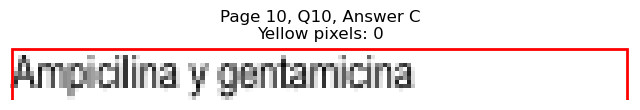

Page 10, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=384.3, y1=758.4
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 320
Page 10, Q10, D: Yellow percentage: 0.0%


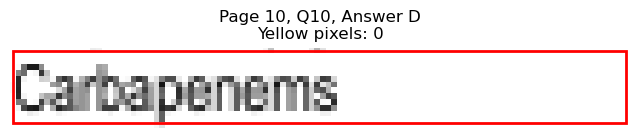


Page 10, Q10 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 4 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=202.2, y1=127.3
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 650
Page 11, Q1, A: Yellow percentage: 0.0%


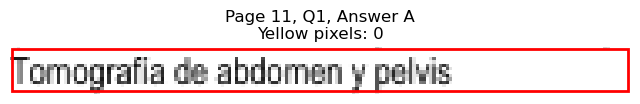

Page 11, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=171.1, y1=139.9
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 536
Page 11, Q1, B: Yellow percentage: 0.0%


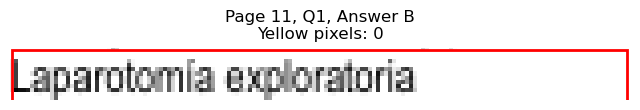

Page 11, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=473.0, y1=127.3
Page 11, Q1, C: Yellow pixels: 1806
Page 11, Q1, C: Total non-white pixels: 2758
Page 11, Q1, C: Yellow percentage: 65.5%


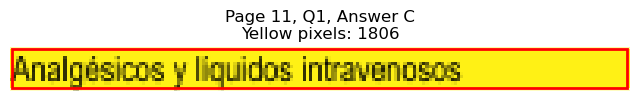

Page 11, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=432.9, y1=139.9
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 693
Page 11, Q1, D: Yellow percentage: 0.0%


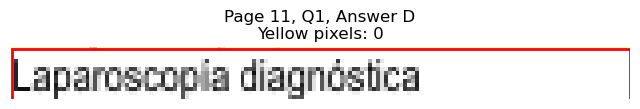


Page 11, Q1 - Selected Answer: C (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=65.2, y1=177.8
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 122
Page 11, Q2, A: Yellow percentage: 0.0%


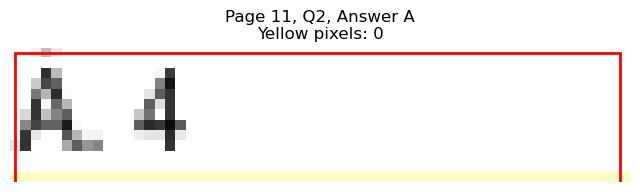

Page 11, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=65.2, y1=190.4
Page 11, Q2, B: Yellow pixels: 663
Page 11, Q2, B: Total non-white pixels: 840
Page 11, Q2, B: Yellow percentage: 78.9%


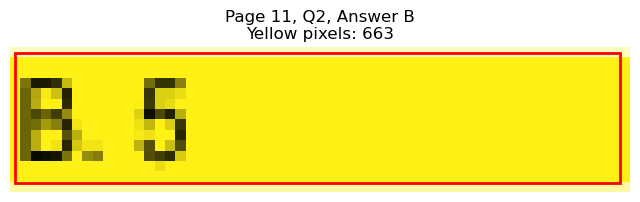

Page 11, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 66
Page 11, Q2, C: Yellow percentage: 0.0%


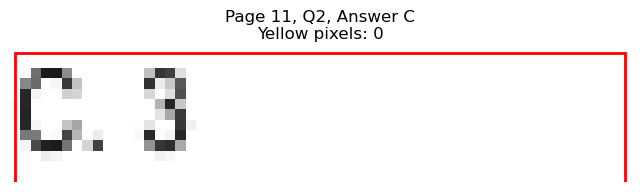

Page 11, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=324.4, y1=190.4
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 66
Page 11, Q2, D: Yellow percentage: 0.0%


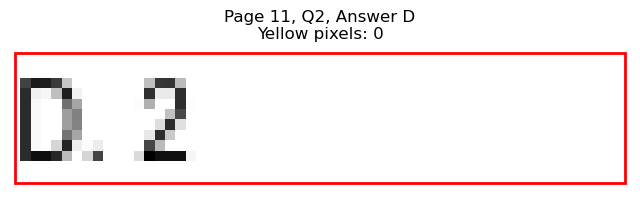


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=162.6, y1=240.9
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 595
Page 11, Q3, A: Yellow percentage: 0.0%


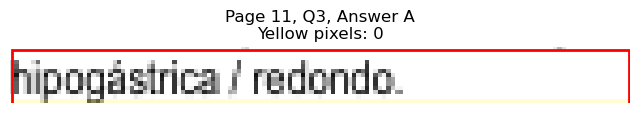

Page 11, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=194.2, y1=253.5
Page 11, Q3, B: Yellow pixels: 1814
Page 11, Q3, B: Total non-white pixels: 2478
Page 11, Q3, B: Yellow percentage: 73.2%


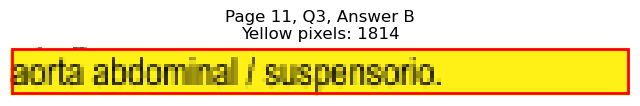

Page 11, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=434.9, y1=240.9
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 519
Page 11, Q3, C: Yellow percentage: 0.0%


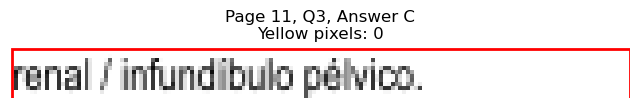

Page 11, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=436.4, y1=253.5
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 524
Page 11, Q3, D: Yellow percentage: 0.0%


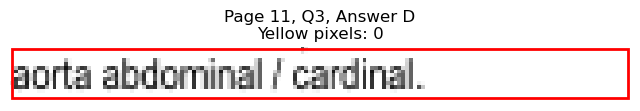


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=152.1, y1=316.7
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 515
Page 11, Q4, A: Yellow percentage: 0.0%


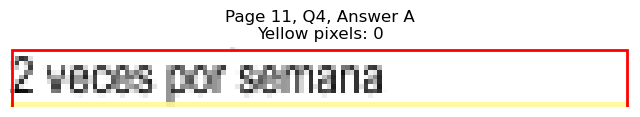

Page 11, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=142.6, y1=329.3
Page 11, Q4, B: Yellow pixels: 1249
Page 11, Q4, B: Total non-white pixels: 1750
Page 11, Q4, B: Yellow percentage: 71.4%


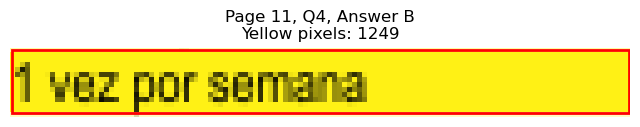

Page 11, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=389.2, y1=316.7
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 306
Page 11, Q4, C: Yellow percentage: 0.0%


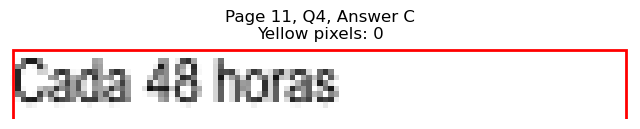

Page 11, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=389.2, y1=329.3
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 289
Page 11, Q4, D: Yellow percentage: 0.0%


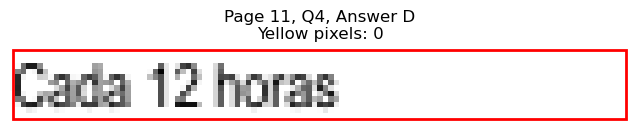


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Hacia la semana ...... de gestación, el número...
1   ¿A qué estadío de Tanner corresponde el desarr...
2   Primigesta de 39 semanas. Antecedente de miome...
3   Paciente de 55 años asintomática, durante su c...
4   Primigesta de 37 semanas, acude a emergencia p...
..                                                ...
95  Puérpera con insuficiencia renal crónica, en s...
96  Mujer de 43 años, presenta miomatosis uterina ...
97  ¿Hasta cuántos días después del intercurso sex...
98  En la punción folicular con guía ecográfica pa...
99  Primigesta de 34 semanas, acude a control pren...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                              20   
1                                               1   
2                           Inducir con oxitocina   
3                     Drenaje con guía ecográfica   
4   24 horas después de iniciada las convulsiones   
..                                            ...   
95                     Clindamicina y gentamicina   
96                 Tomografía de abdomen y pelvis   
97                                              4   
98                        hipogástrica / redondo.   
99                             2 veces por semana   

                          option_B                             option_C  \
0                               12                                   32   
1                                3                                    2   
2        Reevaluación en dos horas       Hospitalización para monitoreo   
3                      Observación           Quistectomía laparoscópica   
4       24 horas después del parto   12 horas después del alumbramiento   
..                             ...                                  ...   
95        Clindamicina y aztreonam             Ampicilina y gentamicina   
96        Laparotomía exploratoria  Analgésicos y líquidos intravenosos   
97                               5                                    3   
98  aorta abdominal / suspensorio.         renal / infundíbulo pélvico.   
99                1 vez por semana                        Cada 48 horas   

                                         option_D  
0                                              36  
1                                               4  
2                           Cesárea de emergencia  
3                                     Laparotomía  
4   12 horas después de iniciada las convulsiones  
..                                            ...  
95                                    Carbapenems  
96                       Laparoscopía diagnóstica  
97                                              2  
98                    aorta abdominal / cardinal.  
99                                  Cada 12 horas  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               C
2               D
3               B
4               B
..            ...
95              B
96              C
97              B
98              B
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Hacia la semana ...... de gestación, el número...   
1   ¿A qué estadío de Tanner corresponde el desarr...   
2   Primigesta de 39 semanas. Antecedente de miome...   
3   Paciente de 55 años asintomática, durante su c...   
4   Primigesta de 37 semanas, acude a emergencia p...   
..                                                ...   
95  Puérpera con insuficiencia renal crónica, en s...   
96  Mujer de 43 años, presenta miomatosis uterina ...   
97  ¿Hasta cuántos días después del intercurso sex...   
98  En la punción folicular con guía ecográfica pa...   
99  Primigesta de 34 semanas, acude a control pren...   

                                         option_A  \
0                                              20   
1                                               1   
2                           Inducir con oxitocina   
3                     Drenaje con guía ecográfica   
4   24 horas después de iniciada las convulsiones   
..                                            ...   
95                     Clindamicina y gentamicina   
96                 Tomografía de abdomen y pelvis   
97                                              4   
98                        hipogástrica / redondo.   
99                             2 veces por semana   

                          option_B                             option_C  \
0                               12                                   32   
1                                3                                    2   
2        Reevaluación en dos horas       Hospitalización para monitoreo   
3                      Observación           Quistectomía laparoscópica   
4       24 horas después del parto   12 horas después del alumbramiento   
..                             ...                                  ...   
95        Clindamicina y aztreonam             Ampicilina y gentamicina   
96        Laparotomía exploratoria  Analgésicos y líquidos intravenosos   
97                               5                                    3   
98  aorta abdominal / suspensorio.         renal / infundíbulo pélvico.   
99                1 vez por semana                        Cada 48 horas   

                                         option_D correct_answer  
0                                              36              A  
1                                               4              C  
2                           Cesárea de emergencia              D  
3                                     Laparotomía              B  
4   12 horas después de iniciada las convulsiones              B  
..                                            ...            ...  
95                                    Carbapenems              B  
96                       Laparoscopía diagnóstica              C  
97                                              2              B  
98                    aorta abdominal / cardinal.              B  
99                                  Cada 12 horas              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/GINECOLOGIA.csv
